# 04 - Applied ML

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import networkx.algorithms.matching as matching
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

DATA_DIR = '.'

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Answer:

In order to answer this question, we will load the dataset from the csv file and then perform various visualizations, in order to see if we can come up with any conclusions:

In [2]:
# Load the dataset into a DataFrame
data = pd.read_csv(os.path.join(DATA_DIR, 'lalonde.csv'))
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
# Split the dataset into two datasets, one for the people who received the treatment (treated) and one for the
# people who didn't receive the threatment (control)
treated = data[data['treat'] == 1]
control = data[data['treat'] == 0]

print("Treated: %d, Control: %d)" % (len(treated), len(control)))

Treated: 185, Control: 429)


First, we show useful information regarding the column "re78" in both datasets, using the function "describe":

In [4]:
treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [5]:
control['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

We observe that in the control group, the mean value of the column is slightly higher than in the treated group. Apart from that, the standard deviation from the mean value, seems to be smaller in the control group than in the treated group. This shows that, on average, individuals that have not received the treatment, seem to have received a slightly higher income during 1978.

In order to get even more useful information regarding the data, we create two histograms of the frequency with which a certain income shows up, in the treated group and the control group:

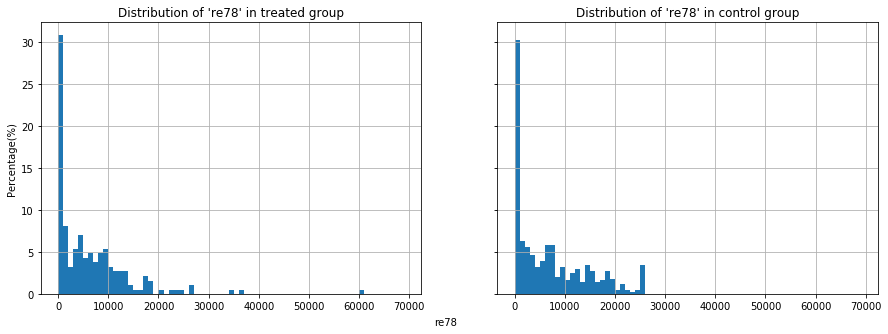

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re78'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), title="Distribution of 're78' in treated group", 
                          bins=[x*1000 for x in range(70)],
                          weights=np.zeros_like(treated['re78']) + 1. / treated['re78'].size * 100)

control['re78'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), title="Distribution of 're78' in control group", 
                          bins=[x*1000 for x in range(70)],
                          weights=np.zeros_like(control['re78']) + 1. / control['re78'].size * 100)

fig.text(0.5, 0.04, 're78', ha='center')
axes[0].set_ylabel("Percentage(%)")

We also create two box plots for the two groups:

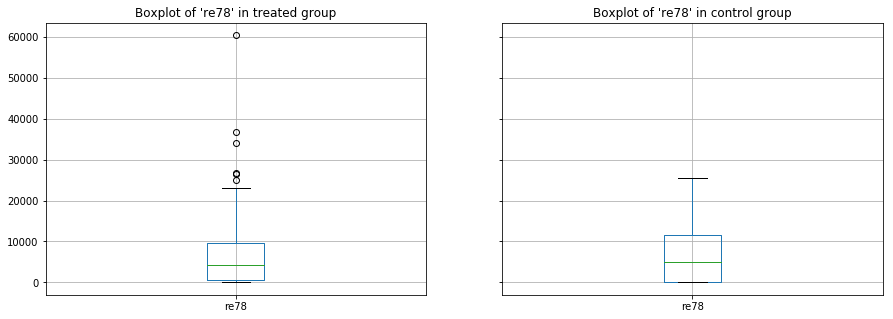

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re78'].plot.box(ax=axes[0], grid=True, figsize=(15,5), title="Boxplot of 're78' in treated group")
control['re78'].plot.box(ax=axes[1], grid=True, figsize=(15,5), title="Boxplot of 're78' in control group")

We observe that the two distributions look very similar, as far as the median and quartiles are concerned. The distribution histograms show a lot of similarities as well. Generally, for both groups, a very big percentage of individuals (around 75%) had an income of 0-10,000 in 1978, while the remaining ~25% had salaries that ranged from 10,000 to 25,000. There are unemployed people (re78 = 0) in both groups, with a very close percentage (around 31%-32% for both). However, there are treated individuals with an income higher than 25,000 (up until 60,000), but their percentage is very small, therefore they are considered to be outliers.

From all the above, a naive "researcher" could conclude that the training seems to have a relatively small impact to the salaries of the trained individuals, compared to the untrained ones. All in all, the training could be considered to be a bit unsuccessful.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Answer

We continue to observe the data by doing exactly what the description dictates: for each feature (column) of the two datasets, we examine its distribution in the corresponding group (mainly by using the "describe" function, as well as histograms, bar plots and box plots) and we describe our observations.

1) We examine the age of the individuals in the two groups:

In [8]:
treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [9]:
control['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

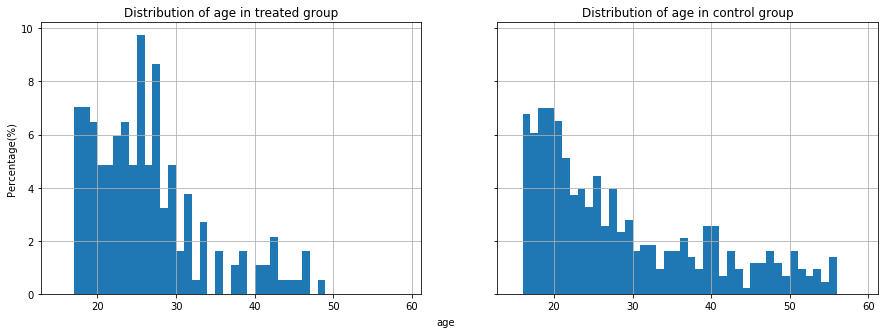

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['age'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), title="Distribution of age in treated group", 
                         bins=[x for x in range(15, 60)], 
                         weights=np.zeros_like(treated['age']) + 1. / treated['age'].size * 100)


control['age'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), title="Distribution of age in control group", 
                         bins=[x for x in range(15, 60)],
                         weights=np.zeros_like(control['age']) + 1. / control['age'].size * 100)

fig.text(0.5, 0.04, 'age', ha='center')
axes[0].set_ylabel("Percentage(%)")

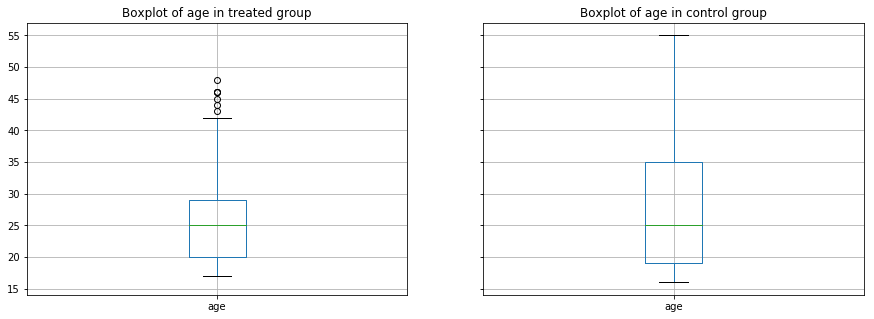

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['age'].plot.box(ax=axes[0], grid=True, figsize=(15,5), title="Boxplot of age in treated group")
control['age'].plot.box(ax=axes[1], grid=True, figsize=(15,5), title="Boxplot of age in control group")

In general, the ages of people seem to be quite different in the two groups. In the treated group, the relative amount of people with ages between 25 and 28 y.o. is quite significantly higher than the relative amount of individuals of this age group in the control group. On the other hand, in the control group, there is a certain amount of older (>48 years old) individuals, while in the treated group, the maximum age is 42 y.o (apart from a few outliers). Generally, just by looking at the two histograms and the two boxplots, it is relatively obvious that the age distributions in the two groups are not at all close.

2) We examine the years of education of the individuals in the two groups:

In [12]:
treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [13]:
control['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

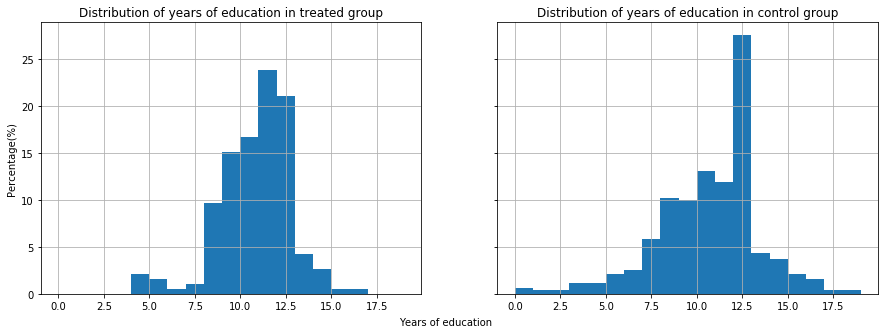

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['educ'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                          title="Distribution of years of education in treated group", 
                          bins=[x for x in range(0, 20)],
                          weights=np.zeros_like(treated['educ']) + 1. / treated['educ'].size * 100)

control['educ'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                          title="Distribution of years of education in control group", 
                          bins=[x for x in range(0, 20)],
                          weights=np.zeros_like(control['educ']) + 1. / control['educ'].size * 100)

fig.text(0.5, 0.04, 'Years of education', ha='center')
axes[0].set_ylabel("Percentage(%)")

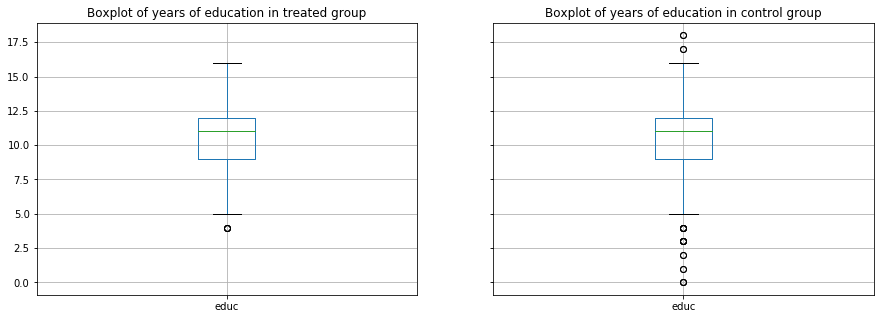

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['educ'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                          title="Boxplot of years of education in treated group")

control['educ'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                          title="Boxplot of years of education in control group")

Some differences between the individuals of the two groups can also be observed regarding their years of education. Indicatively, we can mention that, the largest percentage of treated individuals (~23%) has had around 11 years of education, while the largest percentage of non-treated people (~27%) has had around 12-13 years of education. By looking at the histograms and boxplots, however, we can see that the general shape of the distributions doesn't seem to differ that much between the two groups. More specifically, in both groups, the biggest percentages seem to be concentrated in the middle values of the histogram (8-13 y.o.e), while smaller percentages are concentrated on the sides of the histogram.

3) We examine the race of the individuals in the two groups:

In [16]:
# We observe:
# a) the percentage of black people in the treated group:
print("\033[4mBlack\033[0m people take up %d%% of the treated group" % 
      (round(treated['black'].sum()/len(treated) * 100)))

# b) the percentage of hispanic people in the treated group:
print("\033[4mHispanic\033[0m people take up %d%% of the treated group" % 
      (round(treated['hispan'].sum()/len(treated) * 100)))

# c) the percentage of white people in the treated group:
treated_white = treated[(treated['black'] == 0) & (treated['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(treated_white)/len(treated) * 100)))

# d) the percentage of black people in the control group:
print("\033[4mBlack\033[0m people take up %d%% of the control group" % 
      (round(control['black'].sum()/len(control) * 100)))

# e) the percentage of hispanic people in the control group:
print("\033[4mHispanic\033[0m people take up %d%% of the control group" % 
      (round(control['hispan'].sum()/len(control) * 100)))

# f) the percentage of white people in the control group:
control_white = control[(control['black'] == 0) & (control['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(control_white)/len(control) * 100)))


Black people take up 84% of the treated group
Hispanic people take up 6% of the treated group
White people take up 10% of the treated group

Black people take up 20% of the control group
Hispanic people take up 14% of the control group
White people take up 66% of the treated group



Surprisingly, the distribution of people into the three races varies significantly between the two groups. We visualize this discrepancy with a bar plot:

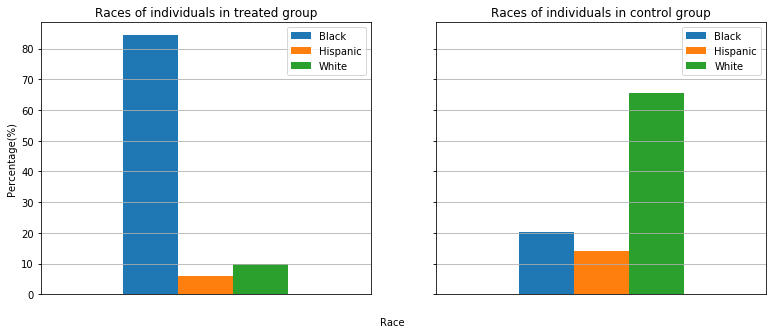

In [17]:
treated_races = pd.DataFrame({'Black' :  pd.Series(treated['black'].sum()/len(treated) * 100),
                              'Hispanic' : pd.Series(treated['hispan'].sum()/len(treated) * 100),
                              'White' : pd.Series(len(treated_white)/len(treated) * 100)})


control_races = pd.DataFrame({'Black' :  pd.Series(control['black'].sum()/len(control) * 100),
                              'Hispanic' : pd.Series(control['hispan'].sum()/len(control) * 100),
                              'White' : pd.Series(len(control_white)/len(control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_races.plot(ax=axes[0], y=['Black', 'Hispanic', 'White'], kind="bar",
                   figsize=(13, 5), title="Races of individuals in treated group", grid=True)

control_races.plot(ax=axes[1], y=['Black', 'Hispanic', 'White'], kind="bar", 
                   figsize=(13, 5), title="Races of individuals in control group", grid=True)

fig.text(0.5, 0.04, 'Race', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

It becomes apparent that there is a huge difference between the two groups, regarding people's races. Almost the entirety of the treated group consists of black people (84%), while there is a small percentage of hispanic and white people. On the other hand the control group is consisted mainly of white people (66%) and less black and white people.

4) We examine the percentage of married and unmarried people in the two groups:

In [18]:
# We observe:
# a) the percentage of married people in the treated group:
print("\033[4mMarried\033[0m people take up %d%% of the treated group" % 
      (round(treated['married'].sum()/len(treated) * 100)))

# b) the percentage of unmarried people in the treated group:
print("\033[4mUnmarried\033[0m people take up %d%% of the treated group\n" % 
      (round((len(treated) - treated['married'].sum())/len(treated) * 100)))
# c) the percentage of married people in the control group:
print("\033[4mMarried\033[0m people take up %d%% of the control group" % 
      (round(control['married'].sum()/len(control) * 100)))

# d) the percentage of unmarried people in the control group:
print("\033[4mUnmarried\033[0m people take up %d%% of the control group" % 
      (round((len(control) - control['married'].sum())/len(control) * 100)))

Married people take up 19% of the treated group
Unmarried people take up 81% of the treated group

Married people take up 51% of the control group
Unmarried people take up 49% of the control group


Similarly to the distribution of races, the distribution of married and unmarried people shows great variance between the two groups. Again, we use a bar plot in order to see the differences clearly:

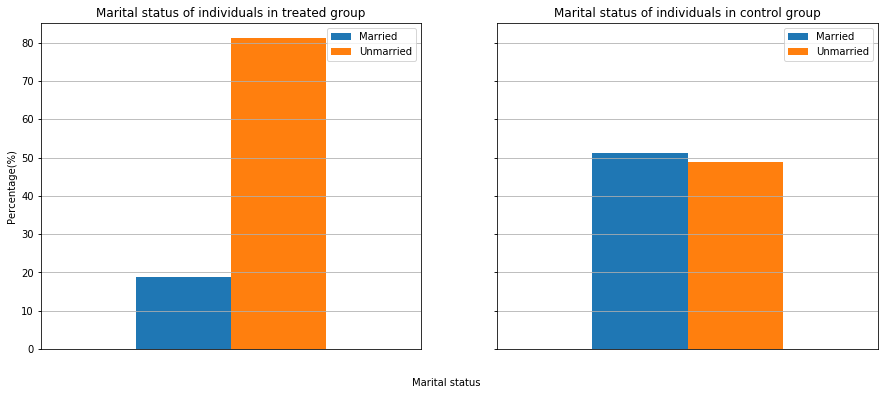

In [19]:
treated_status = pd.DataFrame({'Married' :  pd.Series(treated['married'].sum()/len(treated) * 100),
                               'Unmarried' : pd.Series((len(treated) - treated['married'].sum())
                                                                    /len(treated) * 100)})


control_status = pd.DataFrame({'Married' :  pd.Series(control['married'].sum()/len(control) * 100),
                              'Unmarried' : pd.Series((len(control) - control['married'].sum())
                                                                    /len(control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_status.plot(ax=axes[0], y=['Married', 'Unmarried'], kind="bar",
                   figsize=(15, 6), title="Marital status of individuals in treated group", grid=True)

control_status.plot(ax=axes[1], y=['Married', 'Unmarried'], kind="bar", 
                   figsize=(15, 6), title="Marital status of individuals in control group", grid=True)

fig.text(0.5, 0.04, 'Marital status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

It is obvious that unmarried people take up the majority of the treated group (81%), while in the control group, there are married and unmarried people in fairly equal amounts. 

5) We examine the percentages of people with a school degree and without a school degree in the two groups:

In [20]:
# We observe:
# a) the percentage of people with a degree in the treated group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the treated group" % 
      (round((len(treated) - treated['nodegree'].sum())/len(treated) * 100)))

# b) the percentage of people without a degree in the treated group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the treated group\n" % 
      (round(treated['nodegree'].sum()/len(treated) * 100)))

# c) the percentage of people with a degree in the control group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the control group" % 
      (round((len(control) - control['nodegree'].sum())/len(control) * 100)))

# d) the percentage of people without a degree in the control group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the control group\n" % 
      (round(control['nodegree'].sum()/len(control) * 100)))


People with a school degree take up 29% of the treated group
People without a school degree take up 71% of the treated group

People with a school degree take up 40% of the control group
People without a school degree take up 60% of the control group



We use a bar plot, to visualize the above percentages:

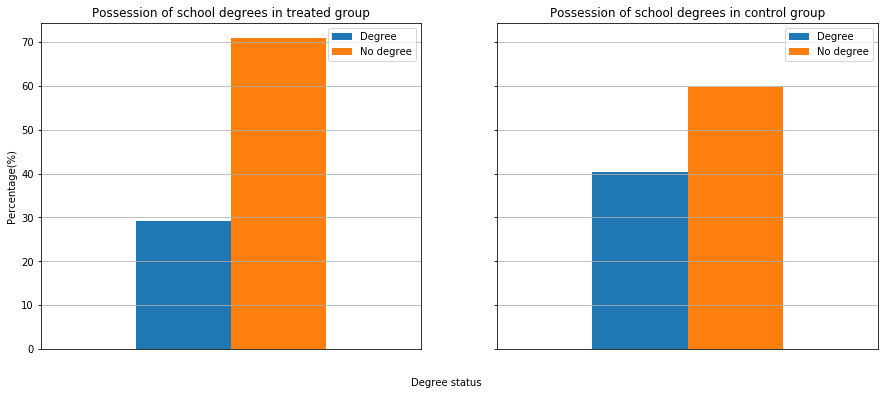

In [21]:
treated_degree = pd.DataFrame({'No degree' :  pd.Series(treated['nodegree'].sum()/len(treated) * 100),
                               'Degree' : pd.Series((len(treated) - treated['nodegree'].sum())
                                                                    /len(treated) * 100)})


control_degree = pd.DataFrame({'No degree' :  pd.Series(control['nodegree'].sum()/len(control) * 100),
                               'Degree' : pd.Series((len(control) - control['nodegree'].sum())
                                                                    /len(control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_degree.plot(ax=axes[0], y=['Degree', 'No degree'], kind="bar",
                   figsize=(15, 6), title="Possession of school degrees in treated group", grid=True)

control_degree.plot(ax=axes[1], y=['Degree', 'No degree'], kind="bar", 
                   figsize=(15, 6), title="Possession of school degrees in control group", grid=True)

fig.text(0.5, 0.04, 'Degree status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

Both groups seem to contain more people without a degree than people with a degree, although in the treated group, the percentage of people with no degree is a little bigger than the corresponding percentage in the control group. All in all however, the feature looks quite balanced in the two groups.

6) We examine the income of individuals in the two groups, during 1974:

In [22]:
treated['re74'].describe()

count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64

In [23]:
control['re74'].describe()

count      429.000000
mean      5619.236506
std       6788.750796
min          0.000000
25%          0.000000
50%       2547.047000
75%       9277.128000
max      25862.320000
Name: re74, dtype: float64

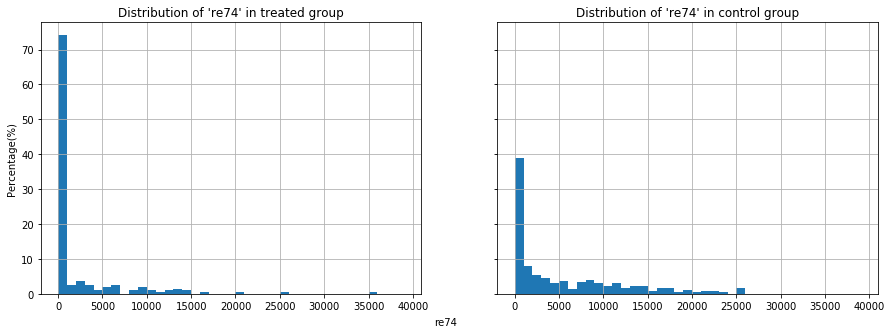

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re74'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), title="Distribution of 're74' in treated group", 
                          bins=[x*1000 for x in range(0, 40)], 
                          weights=np.zeros_like(treated['re74']) + 1. / treated['re74'].size * 100)

control['re74'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), title="Distribution of 're74' in control group", 
                          bins=[x*1000 for x in range(0, 40)], 
                          weights=np.zeros_like(control['re74']) + 1. / control['re74'].size * 100)

fig.text(0.5, 0.04, 're74', ha='center')
axes[0].set_ylabel("Percentage(%)")

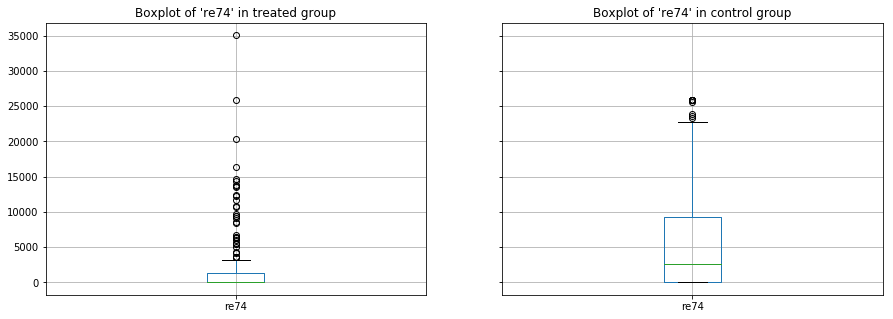

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re74'].plot.box(ax=axes[0], grid=True, figsize=(15,5), title="Boxplot of 're74' in treated group")

control['re74'].plot.box(ax=axes[1], grid=True, figsize=(15,5), title="Boxplot of 're74' in control group")

We can observe that during 1974, the largest percentage (~80%) of treated individuals used to have a very low income (0-3000) and the rest of them had varied incomes from 3000 up until 35000. Regarding the control group, around half of the non-treated individuals had an income of 0-3000, while the other half of the people had incomes that ranged quite smoothly from 3000 up to 25000. Generally, treated individuals used to have lower incomes than non-treated individuals, even though with a few outliers.

7) We examine the income of individuals in the two groups, during 1975:

In [26]:
treated['re75'].describe()

count      185.000000
mean      1532.055314
std       3219.250870
min          0.000000
25%          0.000000
50%          0.000000
75%       1817.284000
max      25142.240000
Name: re75, dtype: float64

In [27]:
control['re75'].describe()

count      429.000000
mean      2466.484443
std       3291.996183
min          0.000000
25%          0.000000
50%       1086.726000
75%       3881.419000
max      18347.230000
Name: re75, dtype: float64

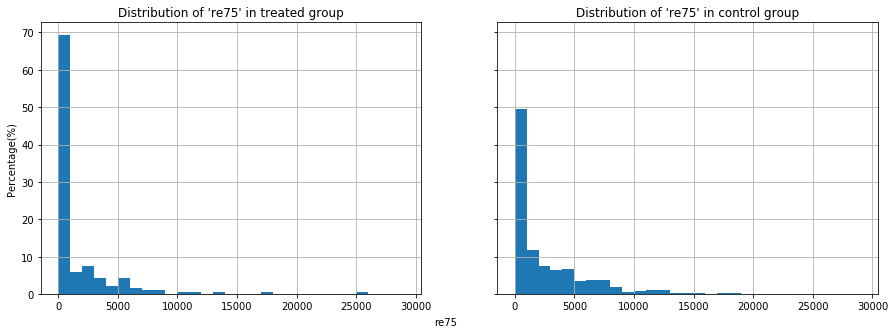

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re75'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), title="Distribution of 're75' in treated group", 
                          bins=[x*1000 for x in range(0, 30)],
                          weights=np.zeros_like(treated['re75']) + 1. / treated['re75'].size * 100)

control['re75'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), title="Distribution of 're75' in control group", 
                          bins=[x*1000 for x in range(0, 30)],
                          weights=np.zeros_like(control['re75']) + 1. / control['re75'].size * 100)

fig.text(0.5, 0.04, 're75', ha='center')
axes[0].set_ylabel("Percentage(%)")

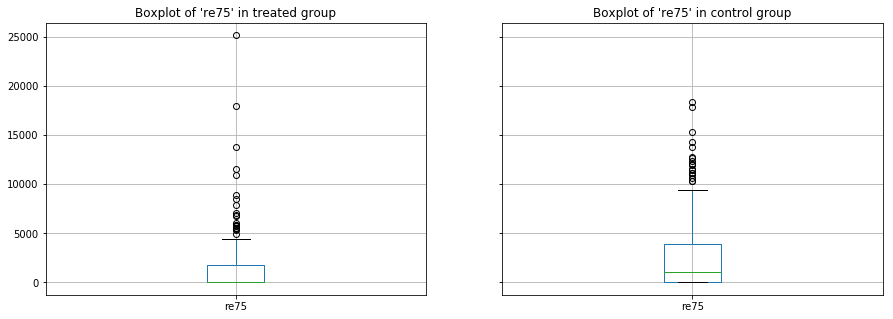

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated['re75'].plot.box(ax=axes[0], grid=True, figsize=(15,5), title="Boxplot of 're75' in treated group")

control['re75'].plot.box(ax=axes[1], grid=True, figsize=(15,5), title="Boxplot of 're75' in control group")

The same trend is observed in the incomes of people during 1975 as in 1974. In general, treated people used to have lower incomes than non-treated people, with a few exceptions (outliers) of people that had the highest incomes out of all the people from both groups.

__Final conclusions:__
The two datasets show a lot of differences and, all in all, they cannot really be compared. Below, we present some of the differences that we observed during our analysis:

1) The majority of treated people belong to the black race, which unfortunately could have an impact on their incomes (racial discrimination is unfortunately still present to this day, let alone during the 70s), while non-treated people are mainly white people. 

2) Treated individuals generally had lower incomes than non-treated ones, or -even worse- were unemployed, during the pre-treatment years, which of course is a factor that leads to their low incomes after the treatment as well. 

3) The control group generally contains people of older ages than the treated group, as well as a higher percentage of married  people, compared to the corresponding percentage in the treated group. These two factors, generally play a big role in people's salaries, for two reasons: a) usually, the older a person is, the bigger their work experience and thus their salary is, and b) married people usually receive some extra income due to their marital status. 

All these discrepancies that have been described above, lead us to the conclusion that we are dealing with two very dissimilar datasets that cannot be compared without being subjected to some processing first.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)



#### Answer

In this part, we are going to use logistic regression in our initial dataset (which contains both treated and non-treated people) in order to calculate the propensity score of each individual (its probability of receiving the treatment, based on its pre-treatment observable features). In other words, in order to classify our data as treated or non-treated.

First, we specify the columns that we are going to use as features. As a first approach, we are choosing to use all of the pre-treatment columns:

In [30]:
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

All of our features are in a vector format, therefore we are ready to construct our classifier:

In [31]:
# We define the X and y:
X = data[features]
y = data['treat']

# We create the logistic regression model:
logistic = LogisticRegression()

# We evaluate the precision (the classifier's ability not to label as positive a sample that is negative) and 
# the recall of the model (the classifier's ability to find all the positive samples), using cross-validation:
precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.62 (+/- 0.47)
Recall: 0.62 (+/- 0.45)


We try using different combinations of features, in order to see if we can come up with a better classifier. We end up with the following set of features, that seems to give a pretty effective classifier (slightly better than the previous one):

In [32]:
features_revised = ['age', 'educ', 'black', 'hispan', 'nodegree', 're74']

In [33]:
# We define the X and y:
X = data[features_revised]
y = data['treat']

# We create the logistic regression model:
logistic = LogisticRegression()

# We evaluate the precision and the recall of the model using cross-validation:
precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.66 (+/- 0.37)
Recall: 0.74 (+/- 0.35)


Finally, we train our model, on the full dataset:

In [34]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We observe the results of the regression by using the method "predict_proba". The method produces an array, in which there is a row for each row of the initial dataset. Each row of the array contains a tuple of kind [probability of 0, probability of 1]. In our case 0 means "non-treated" and 1 means "treated".

In [35]:
prediction = logistic.predict_proba(X)
prediction

array([[ 0.4297173 ,  0.5702827 ],
       [ 0.86074776,  0.13925224],
       [ 0.33297436,  0.66702564],
       ..., 
       [ 0.86421575,  0.13578425],
       [ 0.33241873,  0.66758127],
       [ 0.83227584,  0.16772416]])

Considering that propensity score is defined as "... the conditional probability of treatment Z = 1 given the observed covariates x, or e(x) = Pr(Z = 1 | x)", according to Rosenbaum's book, we only need to keep the second element of each row's tuple. Thus we come up with the following dataframe of propensity scores for each point of the dataset:

In [36]:
prop_scores = pd.DataFrame(data=prediction[:, 1], columns=['p_treatment'])
prop_scores.head()

,p_treatment
0,0.570283
1,0.139252
2,0.667026
3,0.619189
4,0.627288


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### Answer

In order to make our lives easier, we are going to represent our datapoints as vertices of a graph. The graph has to be bipartite, where one set of vertices consists of the treated individuals and the other set of vertices consists of the non-treated individuals, in order to ensure that there are not going to be any matchings (edges) between treated individuals or between non-treated individuals. Thus, the matching of the datapoints that we would like to achieve, is equal to the problem of the <a href="https://en.wikipedia.org/wiki/Matching_(graph_theory)#In_weighted_bipartite_graphs"> maximum weighted bipartite matching </a>.

We will use networkx's "max_weight_matching" method, in order to achieve this matching. We follow the steps bellow:

In [37]:
# Create a bipartite graph consisted of the treated individuals and the non-treated individuals
G = nx.complete_bipartite_graph(len(treated), len(control))

# Create a function that defines the weight of the edge between two vertices (one datapoint from the treated group
# and one from the control group) as the absolute value of the difference of their respective propensity scores.
def weight(i, j):
    return abs(prop_scores.loc[i].values[0] - prop_scores.loc[j].values[0])

# Add the weights defined above, to all the edges of the graph, but with a negative sign, in order to simulate
# a min_weight_matching method
for i in range(len(treated)):
    for j in range(len(treated), len(treated) + len(control)):
        G[i][j]['weight'] = -weight(i, j)

# Apply the max_weight_matching_method to the graph
matched = matching.max_weight_matching(G, maxcardinality=True)

We are now going to create two new dataframes for the treated and control groups of matched individuals: 

In [38]:
# All the datapoints of the initial treated group have been matched, thus we copy the previous dataframe as it is
matched_treated = treated

# We get all the non-treated datapoints that have been matched and add them in a dataframe
matched_control = pd.DataFrame(data=list(matched.keys()))
matched_control = matched_control[matched_control[0] >= 185].sort_values(by=[0])
matched_control = matched_control.set_index([0])

# We fill each datapoint of the new dataframe, with the corresponding features from the initial "control" dataframe
for column in control.columns.values:
       matched_control[column] = control[column]
del matched_control.index.name

print("Size of matched_treated: %d, size of matched_control: %d." % (len(matched_treated), len(matched_control)))

Size of matched_treated: 185, size of matched_control: 185.


We are now ready to compare the "re78" column in both datasets, like we did in question 1:

In [39]:
matched_treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [40]:
matched_control['re78'].describe()

count      185.000000
mean      5084.769193
std       5895.427580
min          0.000000
25%          0.000000
50%       2559.422000
75%       7543.794000
max      20243.380000
Name: re78, dtype: float64

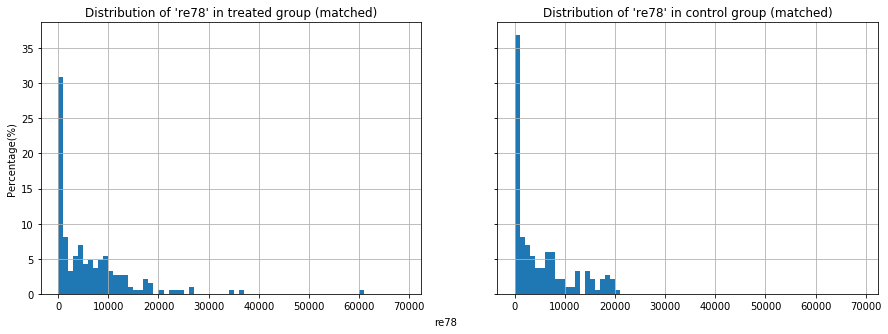

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re78'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're78' in treated group (matched)", 
                        bins=[x*1000 for x in range(0, 70)],          
                        weights=np.zeros_like(matched_treated['re78']) + 1. / matched_treated['re78'].size * 100)

matched_control['re78'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                          title="Distribution of 're78' in control group (matched)", 
                          bins=[x*1000 for x in range(0, 70)],        
                          weights=np.zeros_like(matched_control['re78']) + 1. / matched_control['re78'].size * 100)

fig.text(0.5, 0.04, 're78', ha='center')
axes[0].set_ylabel("Percentage(%)")

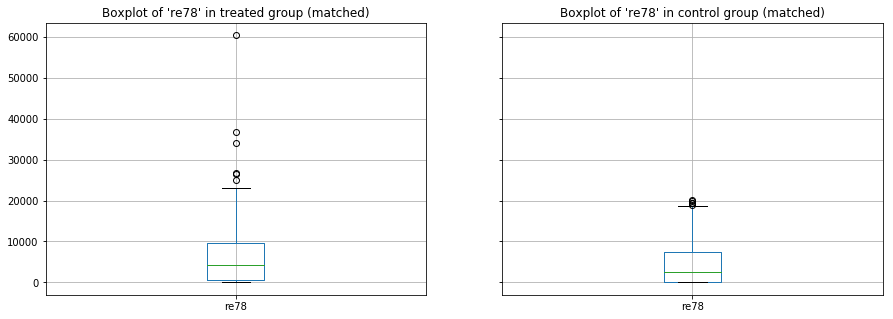

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re78'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of 're78' in treated group (matched)")

matched_control['re78'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                          title="Boxplot of 're78' in control group (matched)")

We can see that after the matching, the two distributions seem to differ a bit more than in task 1. It seems that now, non-treated individuals have low salaries (up to 10,000) or are unemployed at a bigger percentage (~81%), compared to treated individuals (~78%). Unemployed people have a strictly higher percentage in the control group (~37%) than in the treated group (~31%). For salaries above 10,000, the two distributions look pretty similar, like in task 1. Also, there still seem to be a few outliers of people with very high salaries in the treated group, like we observed during our analysis in task 1 too.

We will now compare the distributions of various features in the two groups, like we did in task 1:

1) We examine the age of the individuals in the two groups:

In [43]:
matched_treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [44]:
matched_control['age'].describe()

count    185.000000
mean      23.043243
std        8.897256
min       16.000000
25%       17.000000
50%       20.000000
75%       24.000000
max       55.000000
Name: age, dtype: float64

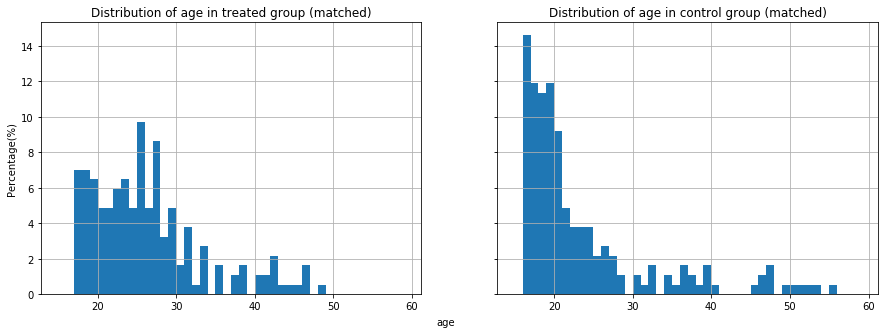

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['age'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                            title="Distribution of age in treated group (matched)",
                            bins=range(15, 60), 
                            weights=np.zeros_like(matched_treated['age']) + 1. / matched_treated['age'].size * 100)

matched_control['age'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                            title="Distribution of age in control group (matched)", 
                            bins=range(15, 60), 
                            weights=np.zeros_like(matched_control['age']) + 1. / matched_control['age'].size * 100)

fig.text(0.5, 0.04, 'age', ha='center')
axes[0].set_ylabel("Percentage(%)")

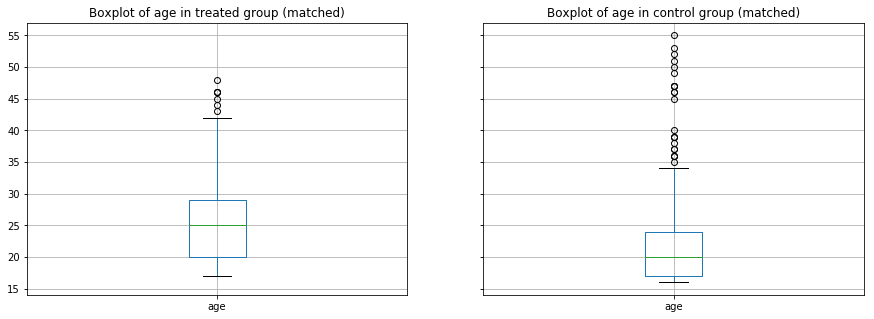

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['age'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                            title="Boxplot of age in treated group (matched)")

matched_control['age'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                            title="Boxplot of age in control group (matched)")


We observe that the age distribution of individuals in the two groups is still very different, even after the matching. This time the control group seems to contain a bigger percentage of young people compared to the treated group, as we can see in the two histograms, which is the opposite of what we observed in task 1. We will probably need to do something more clever than a simple matching based on propensity scores, in order to be able to normalise this discrepancy.

2) We examine the years of education of the individuals in the two groups:

In [47]:
matched_treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [48]:
matched_control['educ'].describe()

count    185.000000
mean      10.037838
std        2.683216
min        1.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64

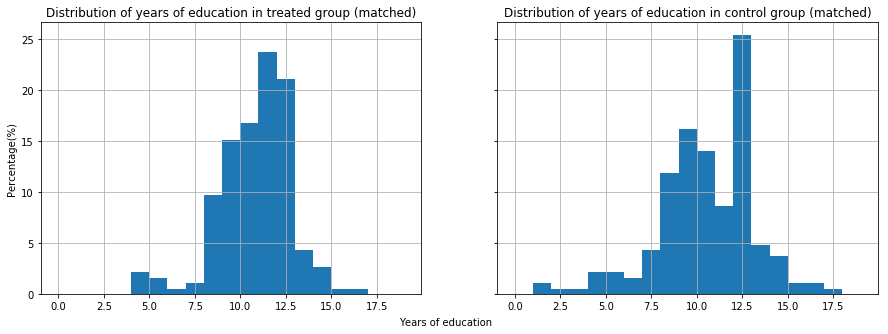

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['educ'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of years of education in treated group (matched)", 
                        bins=range(20), 
                        weights=np.zeros_like(matched_treated['educ']) + 1. / matched_treated['educ'].size * 100)

matched_control['educ'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of years of education in control group (matched)", 
                        bins=range(20), 
                        weights=np.zeros_like(matched_control['educ']) + 1. / matched_control['educ'].size * 100)

fig.text(0.5, 0.04, 'Years of education', ha='center')
axes[0].set_ylabel("Percentage(%)")

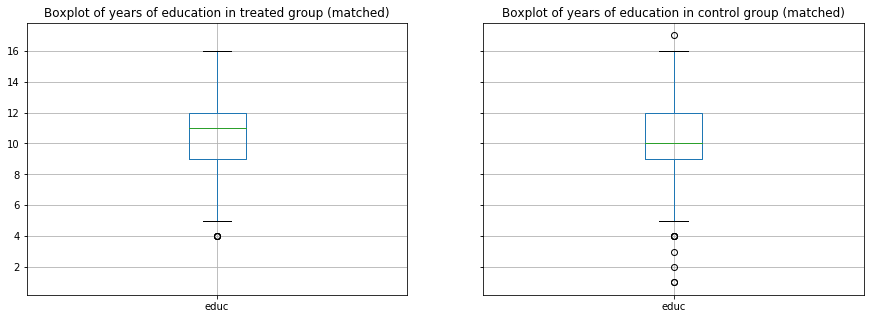

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['educ'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of years of education in treated group (matched)")

matched_control['educ'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of years of education in control group (matched)")

It can be observed that there are quite a few differences between the two distributions (mainly in the percentages of people with 11-13 years of education) However, the mean value, standard deviation and percentiles seem pretty similar in the two groups. Thus, we decided that we can tolerate this kind of difference between the distributions and therefore we will not try to "balance" this feature any further.

3) We examine the race of the individuals in the two groups:

In [51]:
# We observe:
# a) the percentage of black people in the treated group:
print("\033[4mBlack\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['black'].sum()/len(matched_treated) * 100)))

# b) the percentage of hispanic people in the treated group:
print("\033[4mHispanic\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['hispan'].sum()/len(matched_treated) * 100)))

# c) the percentage of white people in the treated group:
treated_white = matched_treated[(matched_treated['black'] == 0) & (matched_treated['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(treated_white)/len(matched_treated) * 100)))

# d) the percentage of black people in the control group:
print("\033[4mBlack\033[0m people take up %d%% of the control group" % 
      (round(matched_control['black'].sum()/len(matched_control) * 100)))

# e) the percentage of hispanic people in the control group:
print("\033[4mHispanic\033[0m people take up %d%% of the control group" % 
      (round(matched_control['hispan'].sum()/len(matched_control) * 100)))

# f) the percentage of white people in the control group:
control_white = matched_control[(matched_control['black'] == 0) & (matched_control['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(control_white)/len(matched_control) * 100)))

Black people take up 84% of the treated group
Hispanic people take up 6% of the treated group
White people take up 10% of the treated group

Black people take up 47% of the control group
Hispanic people take up 9% of the control group
White people take up 44% of the treated group



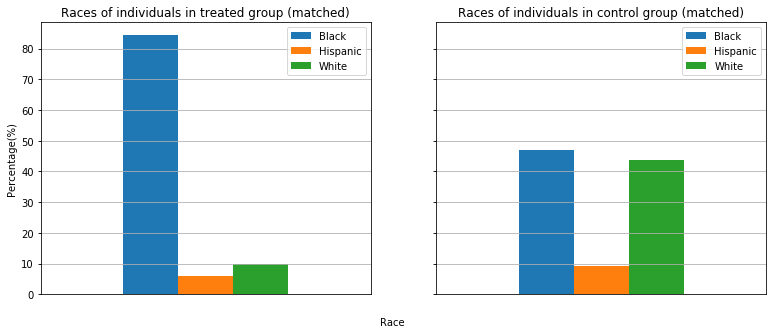

In [52]:
treated_races = pd.DataFrame({'Black' :  pd.Series(matched_treated['black'].sum()/len(matched_treated) * 100),
                              'Hispanic' : pd.Series(matched_treated['hispan'].sum()/len(matched_treated) * 100),
                              'White' : pd.Series(len(treated_white)/len(matched_treated) * 100)})


control_races = pd.DataFrame({'Black' :  pd.Series(matched_control['black'].sum()/len(matched_control) * 100),
                              'Hispanic' : pd.Series(matched_control['hispan'].sum()/len(matched_control) * 100),
                              'White' : pd.Series(len(control_white)/len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_races.plot(ax=axes[0], y=['Black', 'Hispanic', 'White'], kind="bar",
                   figsize=(13, 5), title="Races of individuals in treated group (matched)", grid=True)

control_races.plot(ax=axes[1], y=['Black', 'Hispanic', 'White'], kind="bar", 
                   figsize=(13, 5), title="Races of individuals in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Race', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

As we can see, even after the matching of the two groups, there is still a very big difference between their race distributions. The big majority of the treated group is still consisted of black individuals (~85%), while the control group consists of fairly equal amounts of black and white individuals (40%-45%). It is obvious that we need to find some way in order to balance this feature even more, in order to be able to make any decent conclusions about the effectiveness of the treatment.

4) We examine the percentage of married and unmarried people in the two groups:

In [53]:
# We observe:
# a) the percentage of married people in the treated group:
print("\033[4mMarried\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['married'].sum()/len(matched_treated) * 100)))

# b) the percentage of unmarried people in the treated group:
print("\033[4mUnmarried\033[0m people take up %d%% of the treated group\n" % 
      (round((len(matched_treated) - matched_treated['married'].sum())/len(matched_treated) * 100)))
# c) the percentage of married people in the control group:
print("\033[4mMarried\033[0m people take up %d%% of the control group" % 
      (round(matched_control['married'].sum()/len(matched_control) * 100)))

# d) the percentage of unmarried people in the control group:
print("\033[4mUnmarried\033[0m people take up %d%% of the control group" % 
      (round((len(matched_control) - matched_control['married'].sum())/len(matched_control) * 100)))

Married people take up 19% of the treated group
Unmarried people take up 81% of the treated group

Married people take up 30% of the control group
Unmarried people take up 70% of the control group


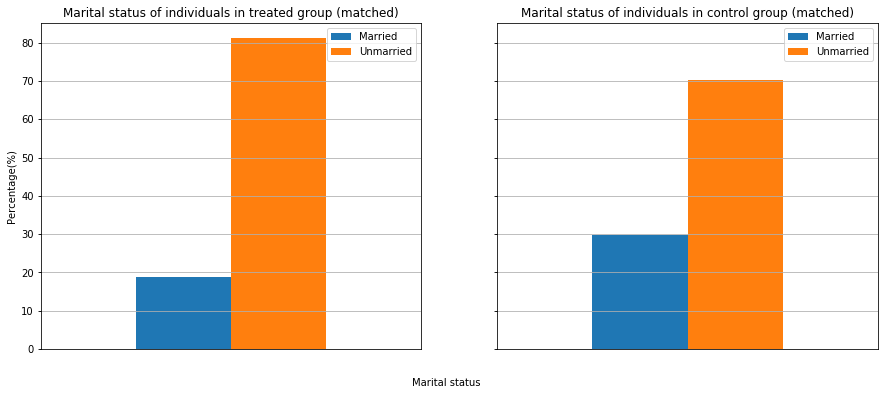

In [54]:
treated_status = pd.DataFrame({'Married' :  pd.Series(matched_treated['married'].sum()/len(matched_treated) * 100),
                               'Unmarried' : pd.Series((len(matched_treated) - matched_treated['married'].sum())
                                                                    /len(matched_treated) * 100)})


control_status = pd.DataFrame({'Married' :  pd.Series(matched_control['married'].sum()/len(matched_control) * 100),
                              'Unmarried' : pd.Series((len(matched_control) - matched_control['married'].sum())
                                                                    /len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_status.plot(ax=axes[0], y=['Married', 'Unmarried'], kind="bar",
                   figsize=(15, 6), title="Marital status of individuals in treated group (matched)", grid=True)

control_status.plot(ax=axes[1], y=['Married', 'Unmarried'], kind="bar", 
                   figsize=(15, 6), title="Marital status of individuals in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Marital status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

We can see that this feature seems to have been sufficiently balanced after the matching, since this time, both groups consist of unmarried people in their majority (70%-80%), as opposed to our observations in task 1.

5) We examine the percentages of people with a school degree and without a school degree:

In [55]:
# We observe:
# a) the percentage of people with a degree in the treated group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the treated group" % 
      (round((len(matched_treated) - matched_treated['nodegree'].sum())/len(matched_treated) * 100)))

# b) the percentage of people without a degree in the treated group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the treated group\n" % 
      (round(matched_treated['nodegree'].sum()/len(matched_treated) * 100)))

# c) the percentage of people with a degree in the control group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the control group" % 
      (round((len(matched_control) - matched_control['nodegree'].sum())/len(matched_control) * 100)))

# d) the percentage of people without a degree in the control group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the control group\n" % 
      (round(matched_control['nodegree'].sum()/len(matched_control) * 100)))


People with a school degree take up 29% of the treated group
People without a school degree take up 71% of the treated group

People with a school degree take up 37% of the control group
People without a school degree take up 63% of the control group



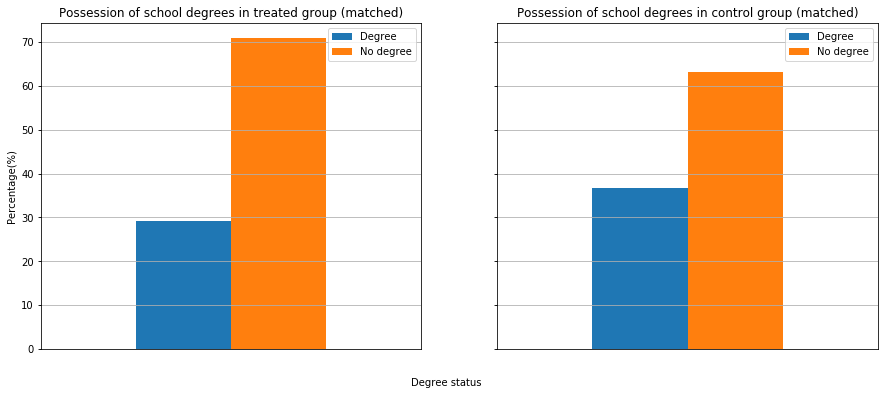

In [56]:
treated_degree = pd.DataFrame({'No degree' : pd.Series(matched_treated['nodegree'].sum()/len(matched_treated) * 100),
                               'Degree' : pd.Series((len(matched_treated) - matched_treated['nodegree'].sum())
                                                                    /len(matched_treated) * 100)})


control_degree = pd.DataFrame({'No degree' : pd.Series(matched_control['nodegree'].sum()/len(matched_control) * 100),
                               'Degree' : pd.Series((len(matched_control) - matched_control['nodegree'].sum())
                                                                    /len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_degree.plot(ax=axes[0], y=['Degree', 'No degree'], kind="bar",
                   figsize=(15, 6), title="Possession of school degrees in treated group (matched)", grid=True)

control_degree.plot(ax=axes[1], y=['Degree', 'No degree'], kind="bar", 
                   figsize=(15, 6), title="Possession of school degrees in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Degree status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

This feature seems quite balanced, since in both groups the majority of individuals don't have a school degree and the percentages of people with and without a degree in the two groups are close enough for the purposes of our analysis.

6) We examine the income of individuals in the two groups, during 1974:

In [57]:
matched_treated['re74'].describe()

count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64

In [58]:
matched_control['re74'].describe()

count      185.000000
mean      2004.923049
std       3948.685589
min          0.000000
25%          0.000000
50%        289.971500
75%       1902.448000
max      21918.320000
Name: re74, dtype: float64

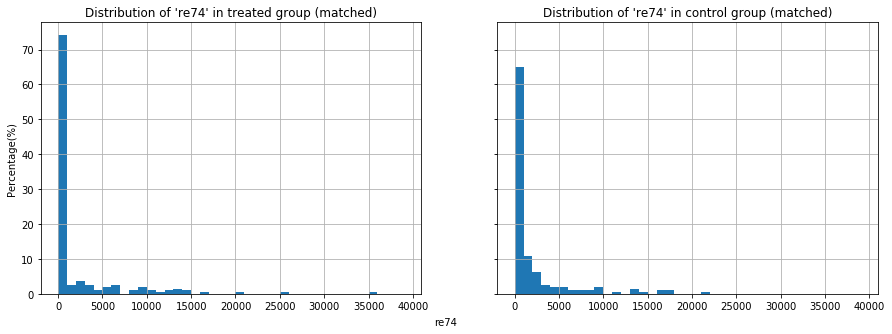

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re74'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're74' in treated group (matched)", 
                        bins=[x*1000 for x in range(40)], 
                        weights=np.zeros_like(matched_treated['re74']) + 1. / matched_treated['re74'].size * 100)

matched_control['re74'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of 're74' in control group (matched)", 
                        bins=[x*1000 for x in range(40)], 
                        weights=np.zeros_like(matched_control['re74']) + 1. / matched_control['re74'].size * 100)

fig.text(0.5, 0.04, 're74', ha='center')
axes[0].set_ylabel("Percentage(%)")

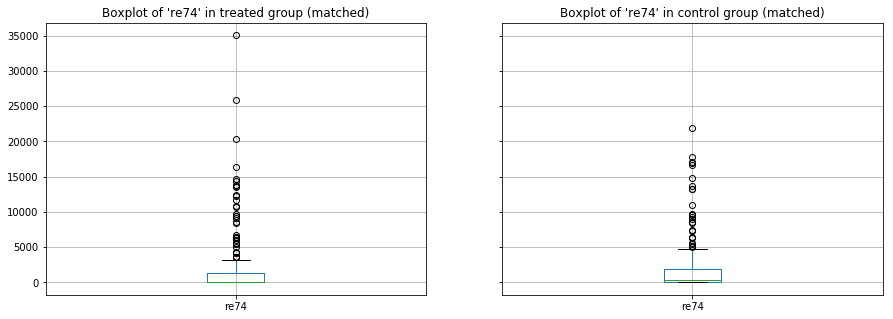

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re74'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of 're74' in treated group (matched)")

matched_control['re74'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of 're74' in control group (matched)")

It is pretty obvious, both from the histograms and the boxplots that this feature has been balanced pretty well after the matching.

7) We examine the income of individuals in the two groups, during 1975:

In [61]:
matched_treated['re75'].describe()

count      185.000000
mean      1532.055314
std       3219.250870
min          0.000000
25%          0.000000
50%          0.000000
75%       1817.284000
max      25142.240000
Name: re75, dtype: float64

In [62]:
matched_control['re75'].describe()

count      185.000000
mean      1338.241906
std       2442.815622
min          0.000000
25%          0.000000
50%        254.225800
75%       1491.339000
max      13776.530000
Name: re75, dtype: float64

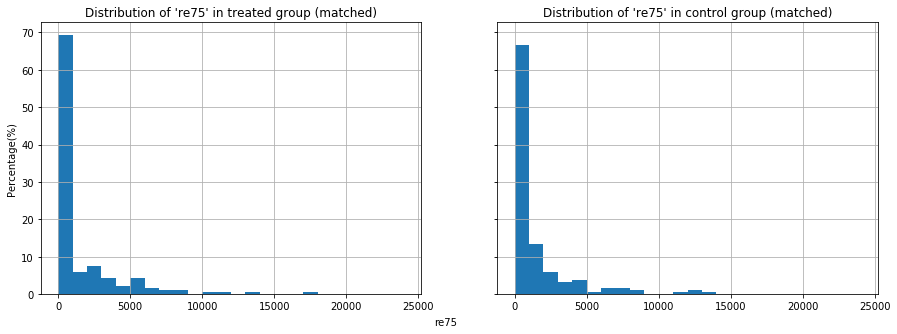

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re75'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're75' in treated group (matched)", 
                        bins=[x*1000 for x in range(25)], 
                        weights=np.zeros_like(matched_treated['re75']) + 1. / matched_treated['re75'].size * 100)

matched_control['re75'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of 're75' in control group (matched)", 
                        bins=[x*1000 for x in range(25)], 
                        weights=np.zeros_like(matched_control['re75']) + 1. / matched_control['re75'].size * 100)

fig.text(0.5, 0.04, 're75', ha='center')
axes[0].set_ylabel("Percentage(%)")

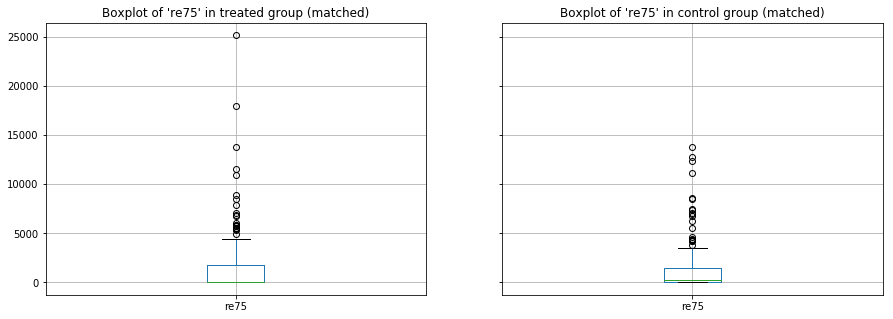

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re75'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of 're75' in treated group (matched)")

matched_control['re75'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of 're75' in control group (matched)")

The two distributions show a lot of similarities after the matching, therefore we consider this feature as well balanced.

__Final conclusions:__

After comparing all the features of the two groups, after the matching, we came to the conclusion that further balancing of two features is needed, in order for us to be able to extract useful information from our dataset. The two features are the __race__ and the __age__ of individuals. In the next task, we will try to find a better way to match the datapoints in our two groups in order to make sure that these two features are properly balanced.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### Answer

In this task we will try to balance the two features that were judged as "unbalanced" during the previous task. 

First, we will try to balance the __race__ feature, by spliting our initial data by race (black/white/hispanic) and by exposure to treatment (treated/control) and by matching the treated and non-treated individuals of each race separately, using the propensity scores that we calculated in task 3:

In [65]:
# form the predicates to split the treated group into races
predicates = {
    'black': treated['black'] == 1,  # black people
    'hispan': treated['hispan'] == 1,  # hispanic people
    'white': (treated['black'] == 0) & (treated['hispan'] == 0),  # white people
}
# put the split dataframes into a dictionary (keys from above: black, hispan, white)
treated_split = {key: treated[pred] for (key, pred) in predicates.items()}

# same for the control group
predicates = {
    'black': control['black'] == 1,  # black people
    'hispan': control['hispan'] == 1,  # hispanic people
    'white': (control['black'] == 0) & (control['hispan'] == 0),  # white people
}
control_split = {key: control[pred] for (key, pred) in predicates.items()}

We have split the treated and control groups according to race. We will now proceed to only match treated individuals with non-treated individuals of the same race, according to the similarity of their propensity scores.

In [66]:
calc_weight = lambda i, j: abs(prop_scores.loc[i].values[0] - prop_scores.loc[j].values[0])

matched_by_race = {}

for race in predicates.keys():
    # extract treated and control groups matching the race
    treated_ = treated_split[race]
    control_ = control_split[race]
    # construct bipartite graph
    G = nx.complete_bipartite_graph(treated_.index.values, control_.index.values)
    # assign weights
    for i in treated_.index.values:
        for j in control_.index.values:
            G[i][j]['weight'] = -calc_weight(i, j)
    # perform matching
    match = matching.max_weight_matching(G, maxcardinality=True)
    match = {k: v for k, v in match.items() if k < len(treated)}
    # form new dataframes for the matched groups
    matched_by_race[race] = {
        'treated': treated_.loc[list(match.keys())],
        'control': control_.loc[list(match.values())],
    }
    # some info on matching...
    weights = [calc_weight(i, j) for (i, j) in match.items()]
    print(race, len(treated_), len(match), ": "
          'sum(weight) = ', sum(weights), ", ",
          'mean(weight) = ', np.mean(weights))

black 156 87 : sum(weight) =  0.513575867238 ,  mean(weight) =  0.00590317088779
hispan 11 11 : sum(weight) =  0.0112266734447 ,  mean(weight) =  0.00102060667679
white 18 18 : sum(weight) =  0.00598058673504 ,  mean(weight) =  0.000332254818613


We are now creating a single dataframe for all the matched treated individuals (called matched_treated) and another one for all the matched non-treaded individuals (called matched_control).

In [67]:
matched_treated = pd.DataFrame()
matched_control = pd.DataFrame()

for race in predicates.keys():
    matched_treated = matched_treated.append(matched_by_race[race]['treated'])
    matched_control = matched_control.append(matched_by_race[race]['control'])

Next, we are going to examine the distribution of each feature in the two groups, like we did after our first matching in task 4:

1) We examine the age of individuals in the two groups:

In [68]:
matched_treated['age'].describe()

count    116.000000
mean      24.879310
std        7.185922
min       17.000000
25%       19.000000
50%       23.000000
75%       28.250000
max       46.000000
Name: age, dtype: float64

In [69]:
matched_control['age'].describe()

count    116.000000
mean      25.698276
std       10.376579
min       16.000000
25%       18.000000
50%       21.000000
75%       31.250000
max       55.000000
Name: age, dtype: float64

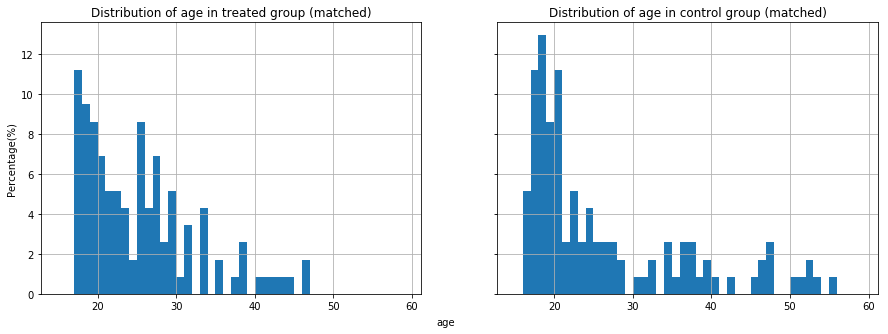

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['age'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                            title="Distribution of age in treated group (matched)",
                            bins=range(15, 60), 
                            weights=np.zeros_like(matched_treated['age']) + 1. / matched_treated['age'].size * 100)

matched_control['age'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                            title="Distribution of age in control group (matched)", 
                            bins=range(15, 60), 
                            weights=np.zeros_like(matched_control['age']) + 1. / matched_control['age'].size * 100)

fig.text(0.5, 0.04, 'age', ha='center')
axes[0].set_ylabel("Percentage(%)")

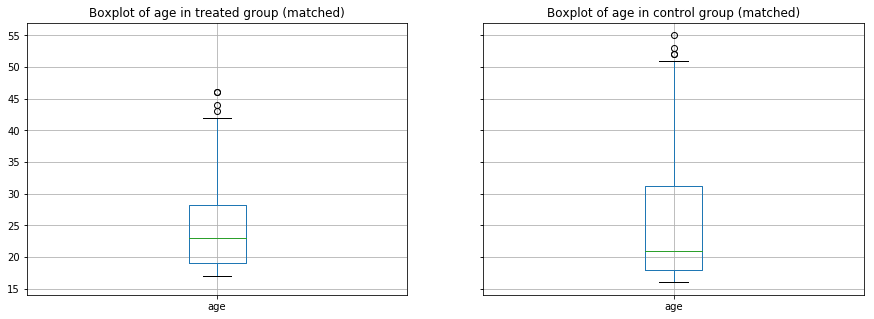

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['age'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                            title="Boxplot of age in treated group (matched)")

matched_control['age'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                            title="Boxplot of age in control group (matched)")

We observe that by forcing the treated and non-treated individuals to have exactly the same race, while also comparing their propensity scores, like before, the age feature seems to be a lot more balanced as well, now. The two distributions, although not entirely similar, have a similar histogram shape, with higher percentages concentrated in the younger age groups (15-20 y.o.) and a pretty steady decline of the percentages in older age groups. After observing the two distributions, we decided that we can tolerate the current discrepancy that can be observed in the distribution of people's age in the two groups, and thus we will not try to balance this feature any further. 

Generally, by forcing certain features to be more balanced, it seems that some other features become more unbalanced (e.g. as we will see for feature 're74' further below), therefore there is a certain tradeoff to each tweak that we choose to do. For the purposes of our analysis, we decided that we will stick with the current matching, in order to avoid "messing" with already balanced features in order to "force-balance" the age feature.

2) We examine the years of education of individuals in the two groups:

In [72]:
matched_treated['educ'].describe()

count    116.000000
mean      10.362069
std        2.057422
min        4.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [73]:
matched_control['educ'].describe()

count    116.000000
mean      10.094828
std        2.933994
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64

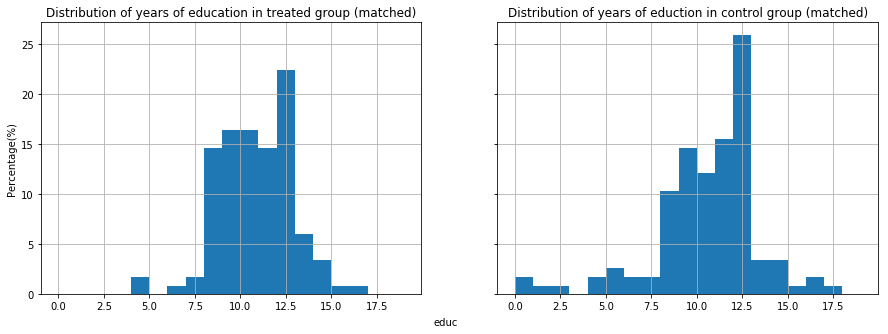

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['educ'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of years of education in treated group (matched)",
                        bins=range(20), 
                        weights=np.zeros_like(matched_treated['educ']) + 1. / matched_treated['educ'].size * 100)

matched_control['educ'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of years of eduction in control group (matched)", 
                        bins=range(20), 
                        weights=np.zeros_like(matched_control['educ']) + 1. / matched_control['educ'].size * 100)

fig.text(0.5, 0.04, 'educ', ha='center')
axes[0].set_ylabel("Percentage(%)")

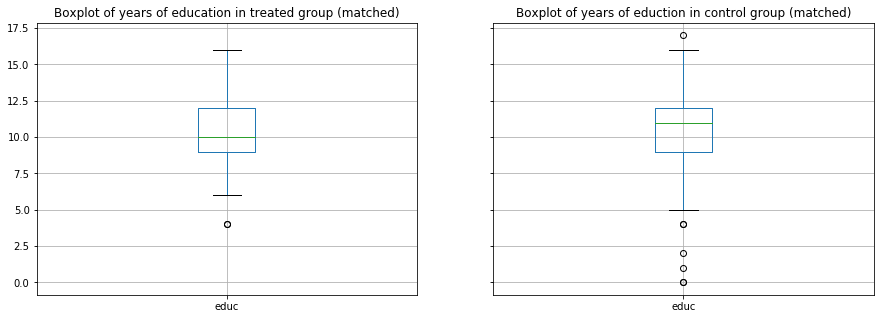

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['educ'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of years of education in treated group (matched)")

matched_control['educ'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of years of eduction in control group (matched)")

We observe that the two distributions look very similar, after our second matching, in terms of histogram shape, mean value and standard deviation as well as the information that we get from the boxplots. The feature seems to have been balanced even more, compared to our first matching.

3) We examine the race of individuals in the two groups:

In [76]:
# We observe:
# a) the percentage of black people in the treated group:
print("\033[4mBlack\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['black'].sum()/len(matched_treated) * 100)))

# b) the percentage of hispanic people in the treated group:
print("\033[4mHispanic\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['hispan'].sum()/len(matched_treated) * 100)))

# c) the percentage of white people in the treated group:
treated_white = matched_treated[(matched_treated['black'] == 0) & (matched_treated['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(treated_white)/len(matched_treated) * 100)))

# d) the percentage of black people in the control group:
print("\033[4mBlack\033[0m people take up %d%% of the control group" % 
      (round(matched_control['black'].sum()/len(matched_control) * 100)))

# e) the percentage of hispanic people in the control group:
print("\033[4mHispanic\033[0m people take up %d%% of the control group" % 
      (round(matched_control['hispan'].sum()/len(matched_control) * 100)))

# f) the percentage of white people in the control group:
control_white = matched_control[(matched_control['black'] == 0) & (matched_control['hispan'] == 0)]
print("\033[4mWhite\033[0m people take up %d%% of the treated group\n" % 
      (round(len(control_white)/len(matched_control) * 100)))

Black people take up 75% of the treated group
Hispanic people take up 9% of the treated group
White people take up 16% of the treated group

Black people take up 75% of the control group
Hispanic people take up 9% of the control group
White people take up 16% of the treated group



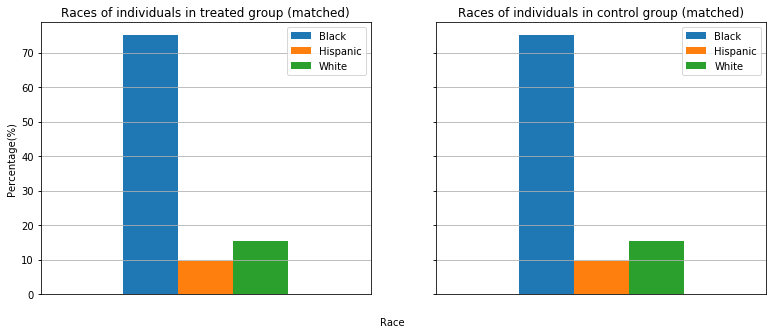

In [77]:
treated_races = pd.DataFrame({'Black' :  pd.Series(matched_treated['black'].sum()/len(matched_treated) * 100),
                              'Hispanic' : pd.Series(matched_treated['hispan'].sum()/len(matched_treated) * 100),
                              'White' : pd.Series(len(treated_white)/len(matched_treated) * 100)})


control_races = pd.DataFrame({'Black' :  pd.Series(matched_control['black'].sum()/len(matched_control) * 100),
                              'Hispanic' : pd.Series(matched_control['hispan'].sum()/len(matched_control) * 100),
                              'White' : pd.Series(len(control_white)/len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_races.plot(ax=axes[0], y=['Black', 'Hispanic', 'White'], kind="bar",
                   figsize=(13, 5), title="Races of individuals in treated group (matched)", grid=True)

control_races.plot(ax=axes[1], y=['Black', 'Hispanic', 'White'], kind="bar", 
                   figsize=(13, 5), title="Races of individuals in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Race', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

As expected, the percentages of black, hispanic and white people in the two groups, are now completely the same, since we explicitly forced our groups to match on this feature exactly.

4) We examine the percentage of married and unmarried people in the two groups:

In [78]:
# We observe:
# a) the percentage of married people in the treated group:
print("\033[4mMarried\033[0m people take up %d%% of the treated group" % 
      (round(matched_treated['married'].sum()/len(matched_treated) * 100)))

# b) the percentage of unmarried people in the treated group:
print("\033[4mUnmarried\033[0m people take up %d%% of the treated group\n" % 
      (round((len(matched_treated) - matched_treated['married'].sum())/len(matched_treated) * 100)))
# c) the percentage of married people in the control group:
print("\033[4mMarried\033[0m people take up %d%% of the control group" % 
      (round(matched_control['married'].sum()/len(matched_control) * 100)))

# d) the percentage of unmarried people in the control group:
print("\033[4mUnmarried\033[0m people take up %d%% of the control group" % 
      (round((len(matched_control) - matched_control['married'].sum())/len(matched_control) * 100)))

Married people take up 14% of the treated group
Unmarried people take up 86% of the treated group

Married people take up 34% of the control group
Unmarried people take up 66% of the control group


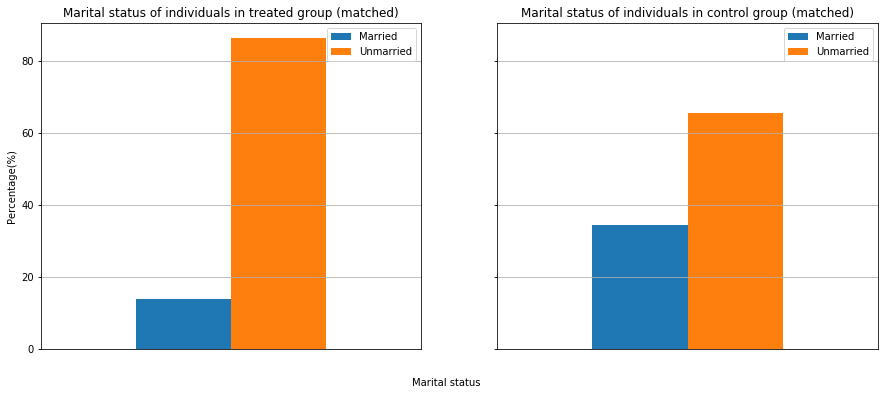

In [79]:
treated_status = pd.DataFrame({'Married' :  pd.Series(matched_treated['married'].sum()/len(matched_treated) * 100),
                               'Unmarried' : pd.Series((len(matched_treated) - matched_treated['married'].sum())
                                                                    /len(matched_treated) * 100)})


control_status = pd.DataFrame({'Married' :  pd.Series(matched_control['married'].sum()/len(matched_control) * 100),
                              'Unmarried' : pd.Series((len(matched_control) - matched_control['married'].sum())
                                                                    /len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_status.plot(ax=axes[0], y=['Married', 'Unmarried'], kind="bar",
                   figsize=(15, 6), title="Marital status of individuals in treated group (matched)", grid=True)

control_status.plot(ax=axes[1], y=['Married', 'Unmarried'], kind="bar", 
                   figsize=(15, 6), title="Marital status of individuals in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Marital status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

The marital status feature seems a bit more unbalanced than after our first matching (the percentage of married people in the treated group is a bit higher than in the control group), however the feature can be considered as pretty balanced, generally, since there are still more unmarried than married people in both groups.

5) We examine the percentages of people with and without a school degree in the two groups:

In [80]:
# We observe:
# a) the percentage of people with a degree in the treated group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the treated group" % 
      (round((len(matched_treated) - matched_treated['nodegree'].sum())/len(matched_treated) * 100)))

# b) the percentage of people without a degree in the treated group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the treated group\n" % 
      (round(matched_treated['nodegree'].sum()/len(matched_treated) * 100)))

# c) the percentage of people with a degree in the control group:
print("People \033[4mwith a school degree\033[0m take up %d%% of the control group" % 
      (round((len(matched_control) - matched_control['nodegree'].sum())/len(matched_control) * 100)))

# d) the percentage of people without a degree in the control group:
print("People \033[4mwithout a school degree\033[0m take up %d%% of the control group\n" % 
      (round(matched_control['nodegree'].sum()/len(matched_control) * 100)))


People with a school degree take up 34% of the treated group
People without a school degree take up 66% of the treated group

People with a school degree take up 36% of the control group
People without a school degree take up 64% of the control group



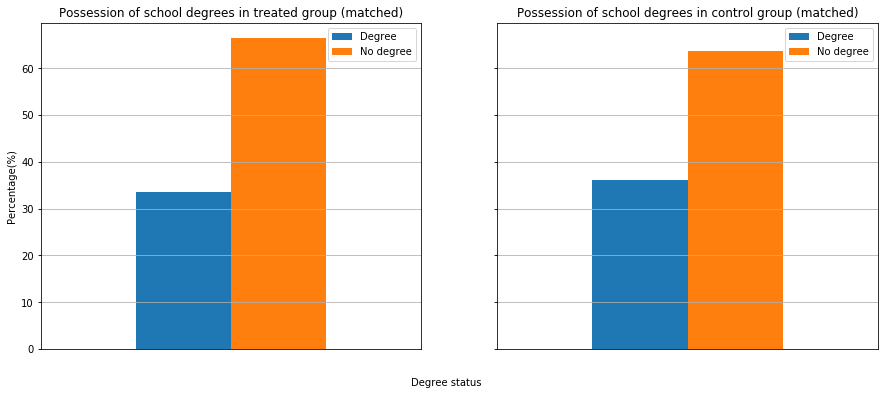

In [81]:
treated_degree = pd.DataFrame({'No degree' : pd.Series(matched_treated['nodegree'].sum()/len(matched_treated) * 100),
                               'Degree' : pd.Series((len(matched_treated) - matched_treated['nodegree'].sum())
                                                                    /len(matched_treated) * 100)})


control_degree = pd.DataFrame({'No degree' : pd.Series(matched_control['nodegree'].sum()/len(matched_control) * 100),
                               'Degree' : pd.Series((len(matched_control) - matched_control['nodegree'].sum())
                                                                    /len(matched_control) * 100)})

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

treated_degree.plot(ax=axes[0], y=['Degree', 'No degree'], kind="bar",
                   figsize=(15, 6), title="Possession of school degrees in treated group (matched)", grid=True)

control_degree.plot(ax=axes[1], y=['Degree', 'No degree'], kind="bar", 
                   figsize=(15, 6), title="Possession of school degrees in control group (matched)", grid=True)

fig.text(0.5, 0.04, 'Degree status', ha='center')
axes[0].set_ylabel("Percentage(%)")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
plt.show()

It is obvious that the second matching has achieved an almost perfect balance in this feature, as we can see from the plots above.

6) We examine the income of individuals in the two groups, during 1974:

In [82]:
matched_treated['re74'].describe()

count      116.000000
mean      2814.626668
std       5893.624805
min          0.000000
25%          0.000000
50%          0.000000
75%       1946.470000
max      35040.070000
Name: re74, dtype: float64

In [83]:
matched_control['re74'].describe()

count      116.000000
mean      2870.798839
std       4741.562606
min          0.000000
25%          0.000000
50%        577.983700
75%       3334.182000
max      21918.320000
Name: re74, dtype: float64

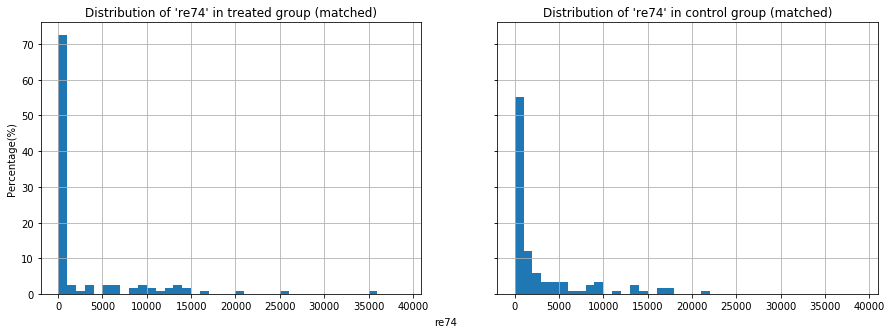

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re74'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're74' in treated group (matched)",
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_treated['re74']) + 1. / matched_treated['re74'].size * 100)

matched_control['re74'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of 're74' in control group (matched)", 
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_control['re74']) + 1. / matched_control['re74'].size * 100)

fig.text(0.5, 0.04, 're74', ha='center')
axes[0].set_ylabel("Percentage(%)")

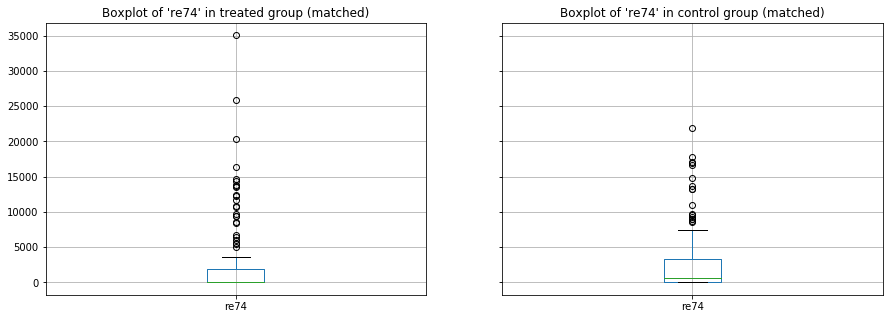

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re74'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                            title="Boxplot of 're74' in treated group (matched)")
matched_control['re74'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                            title="Boxplot of 're74' in control group (matched)")

The 're74' feature seems to have been a bit destabilised, compared to the results that we got after the first matching (the difference of the percentages of unemployed treated and non-treated people is a bit bigger now compared to what we observed in task 4). However, it is considered pretty balanced for the purposes of our analysis.

7) We examine the income of individuals in the two groups, during 1975:

In [86]:
matched_treated['re75'].describe()

count      116.000000
mean      1915.293294
std       3831.034242
min          0.000000
25%          0.000000
50%          0.000000
75%       2622.677750
max      25142.240000
Name: re75, dtype: float64

In [87]:
matched_control['re75'].describe()

count      116.000000
mean      1792.128280
std       3029.327433
min          0.000000
25%          0.000000
50%        287.346750
75%       2262.967500
max      13776.530000
Name: re75, dtype: float64

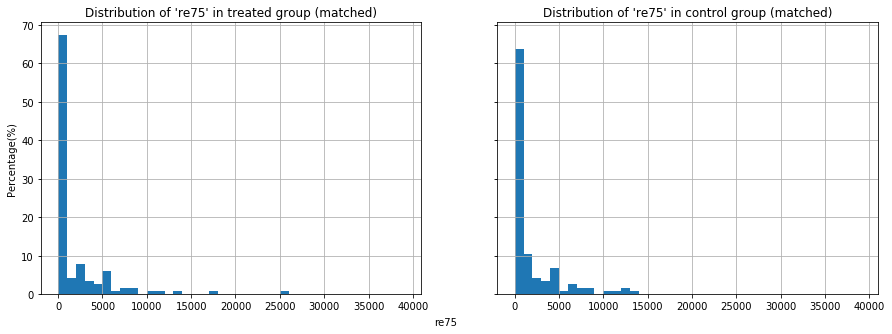

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re75'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're75' in treated group (matched)",
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_treated['re75']) + 1. / matched_treated['re75'].size * 100)

matched_control['re75'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of 're75' in control group (matched)", 
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_control['re75']) + 1. / matched_control['re75'].size * 100)

fig.text(0.5, 0.04, 're75', ha='center')
axes[0].set_ylabel("Percentage(%)")

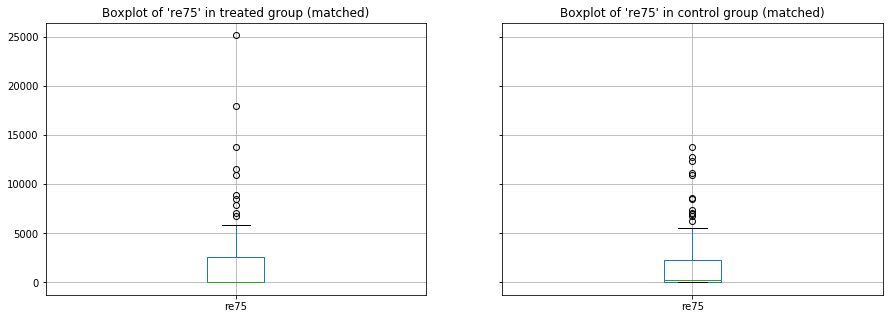

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re75'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of 're75' in treated group (matched)")

matched_control['re75'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of 're75' in control group (matched)")


We can observe that the second matching has achieved a very good balance in this feature.

__Final conclusions:__

As we already mentioned, it seems that there are some features (e.g. marital status, re74) whose balance between the two groups seems a bit worse after the second matching, compared to their balance after the first one, and there are other features (age, race, educ, etc.) whose balance has gotten a lot better after the second matching. All in all, it is quite obvious that after the second matching, most of the features seem well balanced and we can now make safer conclusions regarding the effectiveness of the treatment.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Answer

We are going to compare the income of individuals in the two groups after the treatment (1978):

In [90]:
matched_treated['re78'].describe()

count      116.000000
mean      6600.235531
std       7310.853096
min          0.000000
25%        217.342425
50%       4648.736000
75%       9940.204750
max      36646.950000
Name: re78, dtype: float64

In [91]:
matched_control['re75'].describe()

count      116.000000
mean      1792.128280
std       3029.327433
min          0.000000
25%          0.000000
50%        287.346750
75%       2262.967500
max      13776.530000
Name: re75, dtype: float64

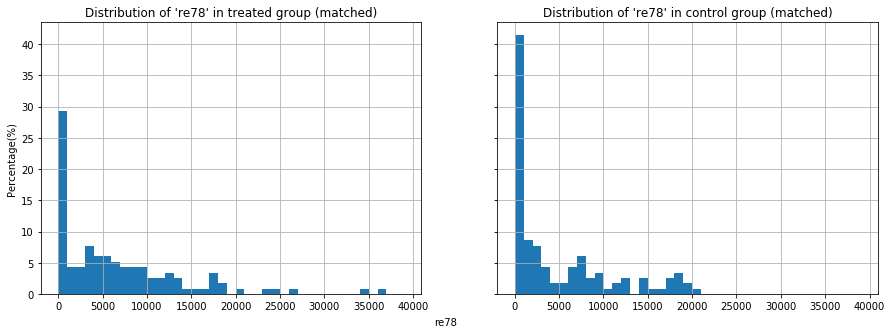

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re78'].plot.hist(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Distribution of 're78' in treated group (matched)",
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_treated['re78']) + 1. / matched_treated['re78'].size * 100)

matched_control['re78'].plot.hist(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Distribution of 're78' in control group (matched)", 
                        bins=[x*1000 for x in range(0, 40)], 
                        weights=np.zeros_like(matched_control['re78']) + 1. / matched_control['re78'].size * 100)

fig.text(0.5, 0.04, 're78', ha='center')
axes[0].set_ylabel("Percentage(%)")

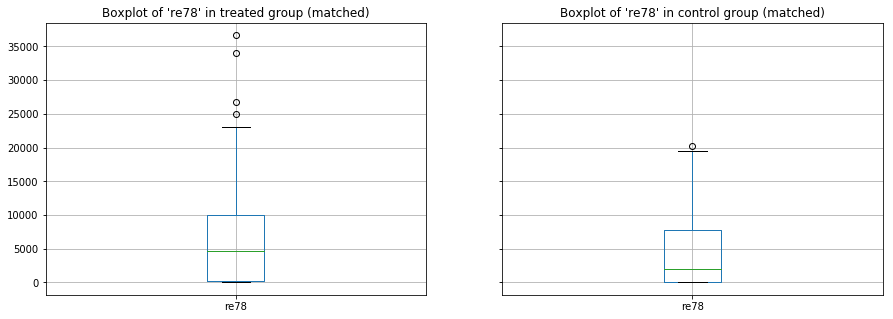

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

matched_treated['re78'].plot.box(ax=axes[0], grid=True, figsize=(15,5), 
                        title="Boxplot of 're78' in treated group (matched)")

matched_control['re78'].plot.box(ax=axes[1], grid=True, figsize=(15,5), 
                        title="Boxplot of 're78' in control group (matched)")

After all our previous processing of the data, we can now make significantly safer conclusions from the data. It turns out that the job training program has been __effective__ after all. We observe the positive results of the program if we notice that the percentage of unemployed people (re78 = 0) in the treated group is now much lower (~29%) than in the control group (~42%). Furthermore, as we can observe from the boxplots above, the maximum income of people during 1978 is higher for treated people (~23,000) than for non-treated ones (~19,000) and there are also a few outliers in the treated group, with incomes much higher than the rest of the peoples' in both groups. Finally, we notice that the mean values in the two groups vary significantly from one another (~6600 for treated individuals and ~1800 for non-treated ones). This means that, on average, people who received the treatment had an income of around 5,000 more than non-treated people, during 1978; a difference which is not at all negligible. 

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

1. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

### Answer

#### Part 1

We first obtain the whole dataset (articles for every category), by setting the argument `subset=all`.

In [94]:
newsgroup_whole = fetch_20newsgroups(subset='all')
type(newsgroup_whole)

sklearn.utils.Bunch

Let's also take a look at the categories.

In [95]:
# the categories of the dataset 20newsgroup are listed below
for index, category in enumerate(newsgroup_whole.target_names):
    print(index, category)

0 alt.atheism
1 comp.graphics
2 comp.os.ms-windows.misc
3 comp.sys.ibm.pc.hardware
4 comp.sys.mac.hardware
5 comp.windows.x
6 misc.forsale
7 rec.autos
8 rec.motorcycles
9 rec.sport.baseball
10 rec.sport.hockey
11 sci.crypt
12 sci.electronics
13 sci.med
14 sci.space
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast
18 talk.politics.misc
19 talk.religion.misc


The `target` attribute contains the category of each article.

In [96]:
newsgroup_whole.target

array([10,  3, 17, ...,  3,  1,  7])

By reading the documentation of fetch_20newsgroups, the `target_names` attribute of the Bunch object shows the categories, the `data` attribute contains the newsgroups posts and the `target` attribute contains the indexes of the corresponding category. To perform tf-idf first we need to do some preprocessing.

In the cell below we show/observe how the articles are structured, in order to perform the appropriate preprocessing steps.

In [97]:
newsgroup_whole.data[10]

"From: sandvik@newton.apple.com (Kent Sandvik)\nSubject: Re: 14 Apr 93   God's Promise in 1 John 1: 7\nOrganization: Cookamunga Tourist Bureau\nLines: 17\n\nIn article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in\nthe blood of the lamb.\n> Mithraist:  washed in the blood of the bull.\n> \n> If anyone in .netland is in the process of devising a new religion,\n> do not use the lamb or the bull, because they have already been\n> reserved.  Please choose another animal, preferably one not\n> on the Endangered Species List.  \n\nThis will be a hard task, because most cultures used most animals\nfor blood sacrifices. It has to be something related to our current\npost-modernism state. Hmm, what about used computers?\n\nCheers,\nKent\n---\nsandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.\n"

We define the following functions to help us with the pre-processing procedure.

In [98]:
def format_text(row):
    """
    Takes a text as input and removes lines that start with specific words
    
    Parameters:
    row: text string
    return: filtered text
    """
    remove_lines = ('in article', '@', 'from:', 'subject:', 'organization:',
                    'lines:', 'nntp-posting-host:', 're:', 'reply-to', 'distribution:',
                    'nntp-posting-host:', 'In article')
    payload = row.split('\n')
    # remove lines that start with a word in the remove_lines list and remove emails 
    payload = [line for line in payload if not (line.startswith(remove_lines))]
    payload = [line for line in payload if '@' not in line]              
    if payload != ' ' and payload != '':
        payload = ' '.join(payload)
    return payload

def convert_to_lowercase(text):
    """
    Converts all words in the article into lower case
    
    Parameters:
    text: text string
    return: text string to lower case
    """
    return text.lower()

def filter_punctuation(text):
    """
    Removes the punctuation.
    
    Parameters:
    text: string
    return: filtered string
    """

    tokenizer = RegexpTokenizer(r'\w+')
    return " ".join(tokenizer.tokenize(text))
    tokenizer = RegexpTokenizer(r'\w+(?:\.|)')
    return " ".join(tokenizer.tokenize(text))

Below we show an example of applying `format_text` to an article.

In [99]:
format_text(newsgroup_whole.data[10])

"Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7 Organization: Cookamunga Tourist Bureau Lines: 17  the blood of the lamb. > Mithraist:  washed in the blood of the bull. >  > If anyone in .netland is in the process of devising a new religion, > do not use the lamb or the bull, because they have already been > reserved.  Please choose another animal, preferably one not > on the Endangered Species List.    This will be a hard task, because most cultures used most animals for blood sacrifices. It has to be something related to our current post-modernism state. Hmm, what about used computers?  Cheers, Kent --- "

As we can see, the "lines" containing the undesired properties have been removed, so that we stay with a "cleaner" payload.

Next, we create a `DataFrame` containing the article texts and their corresponding categories (name and ID). We also convert the article text to lowercase, for easier and more accurate analysis later.

In [100]:
# perform matching in a list
d = []
counterAll = 0
for i, cat in enumerate(newsgroup_whole.target_names):
    counter = 0
    for i1, i2 in enumerate(newsgroup_whole.target):
        if i == i2:
            counter = counter + 1
            temp1 = pd.Series(newsgroup_whole.data[i1])
            temp2 = pd.Series(newsgroup_whole.target[i2])
            d.append({'Text': newsgroup_whole.data[i1],
                      'Category': newsgroup_whole.target[i2],
                      'Cat_Name': newsgroup_whole.target_names[i]})
    counterAll += counter

In [101]:
# create DataFrame out of the list
df = pd.DataFrame(d)
# convert article text to lowercase
df['Text'] = df.apply(lambda row: convert_to_lowercase(row['Text']), axis=1)
df.head()

,Cat_Name,Category,Text
0,alt.atheism,10,from: kmr4@po.cwru.edu (keith m. ryan)\nsubjec...
1,alt.atheism,10,organization: penn state university\nfrom: joh...
2,alt.atheism,10,from: simon@dcs.warwick.ac.uk (simon clippingd...
3,alt.atheism,10,from: ednclark@kraken.itc.gu.edu.au (jeffrey c...
4,alt.atheism,10,from: nanci ann miller <nm0w+@andrew.cmu.edu>\...


Next, we vectorize the words of each article. We make use of the stop-words (words that do not affect the "content type" of a piece of text, such as articles or adverbs) capabilities of the `nltk` library. We also add two words that appear frequently in some artictes and which are "weird".

Observe how we make use of the `format_text` function defined above as the preprocessor in `TfidfVectorizer`.

In [102]:
stop = stopwords.words('english')
stop.append('KSAND')
stop.append('ALink')
vectorizer = TfidfVectorizer(stop_words=stop, lowercase=True, use_idf=True, max_features=150,
                             preprocessor=format_text, norm= 'l2', ngram_range=(1,1), sublinear_tf=True)

In [103]:
# example vectorization for the first article
v = vectorizer.fit_transform([df['Text'][0]])
vectorizer.get_feature_names()

['accepted',
 'afterwards',
 'anywhere',
 'aspect',
 'bucaille',
 'commonly',
 'dr',
 'either',
 'even',
 'fly',
 'galacticentric',
 'geocentrism',
 'heliocentric',
 'intention',
 'learning',
 'long',
 'maurice',
 'noted',
 'notion',
 'positive',
 'qur',
 'sole',
 'time',
 'verse']

The are also a few articles, for which the vectorizer does not yield any results, e.g. article 687:

In [104]:
df['Text'][687]

'from: edwin gans\nsubject: atheism\nnntp-posting-host: 47.107.76.97\norganization: bell-northern research\nlines: 1\n\n \n'

As you can see, there is no "useful" text in the above article (could correspond e.g. to an empty email).

We now add the following columns to our `DataFrame` (`df`):

* The **Features** column, where we store the features for each article, which were obtained after the transformation of text to a matrix of TF-IDF features.
* The **Features_Coeff** column, where we store the weights of each feature.
* The **X** column, where we store the term-document matrix returned from the vectorizer.

In [105]:
# we first construct the lists (that will later become columns)
d1 = d2 = d3 = []
for i, row in df['Text'].iteritems():
    temp1 = temp2 = temp3 = []
    try:
        response = vectorizer.fit_transform([row])
        l1 = vectorizer.get_feature_names()
        for col in response.nonzero()[1]:
            temp1.append(l1[col])
            temp2.append(response[0, col])  
    except: 
        temp1.append([])
        temp2.append([])
    d1.append(temp1)
    d2.append(temp2)
    d3.append(response)

In [106]:
# add the constructed lists as columns (via pd.Series)
df['Features'] = pd.Series(d1)
df['Features_Coeff'] = pd.Series(d2)
df['X'] = pd.Series(d3)

The final `DataFrame` can be seen below.

In [107]:
# peek...
df.head()

,Cat_Name,Category,Text,Features,Features_Coeff,X
0,alt.atheism,10,from: kmr4@po.cwru.edu (keith m. ryan)\nsubjec...,"[positive, 0.174066010635, aspect, 0.174066010...","[positive, 0.174066010635, aspect, 0.174066010...","[positive, 0.174066010635, aspect, 0.174066010..."
1,alt.atheism,10,organization: penn state university\nfrom: joh...,"[positive, 0.174066010635, aspect, 0.174066010...","[positive, 0.174066010635, aspect, 0.174066010...","[positive, 0.174066010635, aspect, 0.174066010..."
2,alt.atheism,10,from: simon@dcs.warwick.ac.uk (simon clippingd...,"(0, 19)\t0.174066010635\n (0, 3)\t0.1740660...","(0, 19)\t0.174066010635\n (0, 3)\t0.1740660...","(0, 19)\t0.174066010635\n (0, 3)\t0.1740660..."
3,alt.atheism,10,from: ednclark@kraken.itc.gu.edu.au (jeffrey c...,"[dwyer, 0.059358580231, says, 0.059358580231, ...","[dwyer, 0.059358580231, says, 0.059358580231, ...","[dwyer, 0.059358580231, says, 0.059358580231, ..."
4,alt.atheism,10,from: nanci ann miller <nm0w+@andrew.cmu.edu>\...,"[dwyer, 0.059358580231, says, 0.059358580231, ...","[dwyer, 0.059358580231, says, 0.059358580231, ...","[dwyer, 0.059358580231, says, 0.059358580231, ..."


Now we proceed to split dataset into training (80%), test (10%) and validation (10%) sets.

In [108]:
# split with the help of NumPy
train, validation, test = np.split(df.sample(frac=1), [int(.8 * len(df)), int(.9 * len(df))])
# make sure we did it correctly...
train.shape[0], validation.shape[0], test.shape[0]

(15076, 1885, 1885)

#### Part 2

We now begin with the second part. We first make the necessary imports.

In [110]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)  # create a forect classifier

In [111]:
# extract the training data: input (X_train) and output (y_train)
X_train = train['X']
y_train = train['Category']

We train the Random Forest Classifier after we transform the train set with the vectorizer.

In [112]:
vectorizer = TfidfVectorizer(stop_words=stop, lowercase=True, use_idf=True,
                             preprocessor=format_text, norm= 'l2', ngram_range=(1,1), sublinear_tf=True)
X_train = vectorizer.fit_transform(train['Text'])

We fit the RF classifier with the `X_train` term-document obtained by the vectorizer.

In [113]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [114]:
y_pred = forest.predict(X_train)

In [115]:
from sklearn import metrics
metrics.accuracy_score(y_train,y_pred)

0.9960201644998673

As we expected the random forest achieved an accuracy of ~100%.

In [116]:
# show importance of each feature
forest.feature_importances_

array([ 0.0005898 ,  0.00018297,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [117]:
forest.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>

We observe that even in the above naive approach some features have very low importance regarding the dataset.

#### Parameter fine-tuning

To find the best values for the hyperparameters of the RF classifier, which are the: **number of trees, depth of trees**, we first train the RF classifier on the train set and then evaluate on the validation set.

First, we search for the optimal **number of trees**.

In [118]:
# we initialize the vectorizer and we call fit_transform on the train set.
vectorizer = TfidfVectorizer(stop_words=stop, lowercase=True, use_idf=True,
                             preprocessor=format_text, norm= 'l2', ngram_range=(1,1), sublinear_tf=True)
X_train = vectorizer.fit_transform(train['Text'])

# after the vectorizer has learned the vocabulary of the train set,
# we transform the validation set to document-term matrix
X_validation = vectorizer.transform(validation['Text'])

In [119]:
# Inputs for the RF Classifier
X = X_train
y = y_train
y_validation = validation['Category'] 

Next, we find the best possible value for the **n_estimators** parameter.

In [120]:
scores_trees = []
num_of_trees = list(range(10, 500, 50))
for trees in num_of_trees:
    forest = RandomForestClassifier(n_estimators=trees, random_state=4, n_jobs=-1)
    print('Running RF ' + str(trees) + ' trees...')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_validation)
    diff = metrics.accuracy_score(y_validation, y_pred)
    scores_trees.append(diff)
    print(diff)

Running RF 10 trees...
0.709814323607
Running RF 60 trees...
0.805305039788
Running RF 110 trees...
0.816445623342
Running RF 160 trees...
0.816976127321
Running RF 210 trees...
0.822811671088
Running RF 260 trees...
0.823872679045
Running RF 310 trees...
0.82599469496
Running RF 360 trees...
0.83023872679
Running RF 410 trees...
0.827586206897
Running RF 460 trees...
0.825464190981


In [121]:
max_test_accuracy = np.max(scores_trees)
max_pos = scores_trees.index(max_test_accuracy)
opt_trees = num_of_trees[max_pos]
print('The best value for the number of estimators is:',opt_trees)

The best value for the number of estimators is: 360


Finally, we find the best value for the **depth** of the RF Classifier.

In [122]:
scores_depth = []
depths = list(range(10, 200, 10))
for depth in depths:
    forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=depth, random_state=4, n_jobs=-1)
    print('Running RF ' + str(depth) + ' depth...')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_validation)
    diff = metrics.accuracy_score(y_validation, y_pred)
    scores_depth.append(diff)
    print(diff)

Running RF 10 depth...
0.519363395225
Running RF 20 depth...
0.658885941645
Running RF 30 depth...
0.727851458886
Running RF 40 depth...
0.761803713528
Running RF 50 depth...
0.775066312997
Running RF 60 depth...
0.79151193634
Running RF 70 depth...
0.79575596817
Running RF 80 depth...
0.798938992042
Running RF 90 depth...
0.805835543767
Running RF 100 depth...
0.812732095491
Running RF 110 depth...
0.815384615385
Running RF 120 depth...
0.815384615385
Running RF 130 depth...
0.818037135279
Running RF 140 depth...
0.818567639257
Running RF 150 depth...
0.824933687003
Running RF 160 depth...
0.820689655172
Running RF 170 depth...
0.823342175066
Running RF 180 depth...
0.8175066313
Running RF 190 depth...
0.823872679045


In [123]:
max_test_accuracy = np.max(scores_depth)
max_pos = scores_depth.index(max_test_accuracy)
opt_depth = depths[max_pos]
print('The best value for the depth of the tree:',opt_depth)

The best value for the depth of the tree: 150


Now that we calculated the best parameter values, we train on train and validation sets (combined) and finally test on the test set.

In [124]:
train_final = train.append(validation)
train_final.shape

(16961, 6)

In [125]:
vectorizer_final = TfidfVectorizer(stop_words=stop,lowercase=True, use_idf=True,preprocessor=format_text, ngram_range=(1,1), sublinear_tf=True)
X = vectorizer.fit_transform(train_final['Text'])
y = train_final['Category']
X_test = vectorizer.transform(test['Text'])
y_test = test['Category']

In [126]:
forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=opt_depth, random_state=4, n_jobs=-1)
forest.fit(X, y)
y_pred = forest.predict(X_test)
acc = metrics.accuracy_score(y_pred, y_test)
print(acc)

0.825464190981


That is, **our model achieved 82.25% accuracy**.

Something interesting is that the accuracy of our model varied from machine to machine (more accurately from OS to OS). For example, in a run on a Linux machine, we got 84.4% accuracy.

We are not sure as to why this is hapenning, but it is more probably due to the floating point arithmetic and minor library differences among the operating systems.

In [127]:
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 81,   4,   1,   0,   5,   1,   3,   0,   1,   2],
       [  2, 173,  11,   0,   2,   4,   3,   0,   3,  16],
       [  1,  10, 168,   0,   7,   0,   1,   0,   1,  12],
       [  1,   1,   0,  14,  13,   0,   7,   2,  13,   4],
       [  0,   1,   0,   0, 247,   1,   7,   1,  11,   9],
       [  0,   2,   0,   0,   4, 135,  17,   0,   3,   7],
       [  1,   8,   3,   0,   2,   5, 259,   0,   6,  11],
       [  1,   8,   2,   0,   5,   0,   1,  74,   0,  12],
       [  0,  12,   3,   0,   6,   0,   1,   1, 152,  12],
       [  0,  12,   7,   0,   9,   0,   4,   1,   2, 253]])

In [128]:
forest.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=360, n_jobs=-1,
            oob_score=False, random_state=4, verbose=0, warm_start=False)>

In [129]:
forest.feature_importances_

array([  6.14826722e-04,   2.42237329e-04,   2.28456927e-06, ...,
         1.95032950e-06,   2.83772821e-06,   2.23761652e-08])

In [132]:
def plot_feature_importances(X, forest):
    """
    Generate a simple plot of the feature importance.
    Parameters
    ----------
    X: features

    forest : a trained random forest classifier
    """
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking (only for the first 20):")
    limit = 20
    if limit > X.shape[1]:
        limit = X.shape[1]
    
    for f in range(limit):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# shows only the first 20 features
plot_feature_importances(X, forest)

Feature ranking (only for the first 20):
1. feature 111408 (0.006335)
2. feature 29377 (0.005571)
3. feature 49144 (0.004851)
4. feature 40011 (0.004814)
5. feature 101377 (0.004448)
6. feature 25802 (0.004438)
7. feature 91927 (0.004088)
8. feature 96684 (0.003967)
9. feature 50626 (0.003713)
10. feature 50921 (0.003632)
11. feature 51152 (0.003543)
12. feature 31909 (0.003300)
13. feature 93214 (0.003290)
14. feature 82270 (0.003270)
15. feature 29576 (0.003196)
16. feature 42919 (0.003195)
17. feature 54451 (0.003028)
18. feature 24485 (0.002917)
19. feature 49158 (0.002854)
20. feature 67418 (0.002804)


#### Conclusion
We observe that the number of features of the Random Forest Classifier is too high and that features are sparse.
This is reasonable since we know that even though RF achieves a very good estimation on the test set, the fact that we are dealing with articles provides too many features. That's also the reason that the best values for the n_estimators and the max_depth are high.